In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_iris
import subprocess
import pyreadr
import math
import os

## R 코드 실행
- 12시간 이상 소요

In [2]:
#####SEIR_V
command = '/home/sysadm/anaconda3/envs/gil/bin/Rscript'
arg = '--vanilla'
path2script = '../../../../02_code/SEIR_V/R/211105/r_swar_211105.R'

retcode = subprocess.call([command, arg, path2script])

In [3]:
# # Date range
file_name_date = '20230531'
start_date = pd.Timestamp('2020-01-22')
sev_start_date = pd.Timestamp("2020-10-01")
pre_date = pd.Timestamp('2021-08-20') # 예측 시작날짜
end_date = pd.Timestamp('2023-05-31') # 예측 끝 날짜
# # train_date = pd.date_range(start_date,pre_date-timedelta(days=1))
# train_date = pd.date_range(start_date,pre_date)

# predict_date = pd.date_range(pre_date,end_date) # 예측 날짜 범위
# date = pd.date_range(seir_start_date,end_date)

# 경로 설정

In [4]:
## Ground-Truth
path_1 = "../../../../01_data/국제/수집데이터_211013.xlsx" # 국제데이터

## output data
path_2 = "../../../../03_result/SEIR_V/211105/seir_v_211105.csv"

## image
save_path = "../../../../04_image/211105/211105/MA/SEIR_V/" # 이미지 저장 폴더

# Ground-Truth
###### (이유엔 데이터)

In [5]:
### 확진자, 사망자
data_case= pd.read_excel(path_1,engine = "openpyxl",sheet_name ='확진자,사망자수(US 제외)' )
data_case=data_case[data_case['Country'] =='South Korea']
data_case['tDate'] = pd.to_datetime(data_case['tDate'], format="%Y-%m-%d")
#df_= df_1_2.drop(['Province1','Province2','Unnamed: 6'], axis=1, inplace=True)
data_case.drop(['Province1','Province2'], axis=1, inplace=True)
data_case = data_case.fillna(0)
data_case.reset_index(drop=True, inplace=True)
# old_data= data_case[ data_case['tDate'].isin(train_date) ] #Confirmed, Deaths
# old_data = old_data.fillna(0)
# old_data

In [6]:
data_case

tDate      Country  Confirmed  Deaths
0   2020-01-22  South Korea        0.0     0.0
1   2020-01-23  South Korea        0.0     0.0
2   2020-01-24  South Korea        1.0     0.0
3   2020-01-25  South Korea        0.0     0.0
4   2020-01-26  South Korea        1.0     0.0
..         ...          ...        ...     ...
615 2021-10-08  South Korea     2172.0    10.0
616 2021-10-09  South Korea     1949.0     6.0
617 2021-10-10  South Korea     1594.0    15.0
618 2021-10-11  South Korea     1297.0     8.0
619 2021-10-12  South Korea     1347.0    11.0

[620 rows x 4 columns]

In [7]:
data_case.loc[[3],['Deaths']].values

array([[0.]])

In [8]:
### 누적 확진자
data_case['Cum_Deaths']=0.0
for i in range(1,len(data_case)):
    data_case.loc[[i],['Cum_Deaths']] = float(data_case.loc[[i],['Deaths']].values)+float(data_case.loc[[i-1],['Cum_Deaths']].values)
data_case

tDate      Country  Confirmed  Deaths  Cum_Deaths
0   2020-01-22  South Korea        0.0     0.0         0.0
1   2020-01-23  South Korea        0.0     0.0         0.0
2   2020-01-24  South Korea        1.0     0.0         0.0
3   2020-01-25  South Korea        0.0     0.0         0.0
4   2020-01-26  South Korea        1.0     0.0         0.0
..         ...          ...        ...     ...         ...
615 2021-10-08  South Korea     2172.0    10.0      2560.0
616 2021-10-09  South Korea     1949.0     6.0      2566.0
617 2021-10-10  South Korea     1594.0    15.0      2581.0
618 2021-10-11  South Korea     1297.0     8.0      2589.0
619 2021-10-12  South Korea     1347.0    11.0      2600.0

[620 rows x 5 columns]

In [9]:
aug20_cum_deaths = float(data_case.loc[data_case['tDate']=='2021-08-20','Cum_Deaths'])
aug20_cum_deaths

2203.0

In [10]:
### 중증자
old_severity= pd.read_excel(path_1, engine = "openpyxl",usecols='A,H',sheet_name ='확진자 관리현황')
old_severity.columns = ['tDate','Severity']
old_severity['tDate'] = pd.to_datetime(old_severity['tDate'], format="%Y-%m-%d")
old_severity = old_severity.fillna(0)
old_severity

tDate  Severity
0   2020-10-01       107
1   2020-10-02       107
2   2020-10-03       104
3   2020-10-04       105
4   2020-10-05       107
..         ...       ...
359 2021-09-25       339
360 2021-09-26       320
361 2021-09-27       319
362 2021-09-28       324
363 2021-09-29       331

[364 rows x 2 columns]

# Result csv

In [11]:
Rt = [2.5, 2.75, 3.0, 3.5, 4.5]

In [12]:
final_list = pd.read_csv(path_2)
final_list = final_list.drop(['Unnamed: 0'],axis=1)
final_list['date'] = pd.to_datetime(final_list['date'], format="%Y-%m-%d")
final_list = final_list[final_list['date']>=pre_date] ##예측 시작날짜 이전 데이터 잘라냄.

final_list

V1          V2          V3          V4    t       date  \
18   211.618006  626.430856  586.923324  123.714269   18 2021-08-20   
19   215.082941  635.469223  592.153892  126.076493   19 2021-08-21   
20   218.158058  642.675047  595.786596  128.123987   20 2021-08-22   
21   220.919316  648.273958  598.053976  129.911194   21 2021-08-23   
22   223.449910  652.544538  599.063389  131.491924   22 2021-08-24   
..          ...         ...         ...         ...  ...        ...   
663    5.959459    9.802106   10.360961    5.439134  663 2023-05-27   
664    5.950634    9.789715   10.342031    5.431664  664 2023-05-28   
665    5.941822    9.777338   10.323133    5.424203  665 2023-05-29   
666    5.933021    9.764975   10.304268    5.416751  666 2023-05-30   
667    5.924232    9.752627   10.285436    5.409309  667 2023-05-31   

            case        V1.1        V2.1        V3.1  ...  min_death.12  \
18   1548.686455  211.618006  626.430856  586.923324  ...     74.388940   
19   1568.782549  215.082941  635.469223  592.153892  ...     80.000869   
20   1584.743688  218.158058  642.675047  595.786596  ...     85.591643   
21   1597.158443  220.919316  648.273958  598.053976  ...     91.154998   
22   1606.549762  223.449910  652.544538  599.063389  ...     96.686034   
..           ...         ...         ...         ...  ...           ...   
663    31.561661   27.645477   45.050773   47.540519  ...  63962.727294   
664    31.514044   27.576657   44.950879   47.420581  ...  63962.727298   
665    31.466496   27.507984   44.851170   47.300906  ...  63962.727302   
666    31.419015   27.439459   44.751647   47.181494  ...  63962.727306   
667    31.371603   27.371081   44.652307   47.062343  ...  63962.727310   

     max_death.12     date.88  t.88  min_death.13  max_death.13     date.89  \
18      75.367054  2021-08-20    18     74.388940     75.367054  2021-08-20   
19      81.163871  2021-08-21    19     80.000869     81.163871  2021-08-21   
20      86.958739  2021-08-22    20     85.591643     86.958739  2021-08-22   
21      92.745716  2021-08-23    21     91.154998     92.745716  2021-08-23   
22      98.520230  2021-08-24    22     96.686034     98.520230  2021-08-24   
..            ...         ...   ...           ...           ...         ...   
663  67068.722726  2023-05-27   663  63865.475360  66962.761856  2023-05-27   
664  67068.722729  2023-05-28   664  63865.475361  66962.761857  2023-05-28   
665  67068.722732  2023-05-29   665  63865.475362  66962.761858  2023-05-29   
666  67068.722735  2023-05-30   666  63865.475363  66962.761859  2023-05-30   
667  67068.722737  2023-05-31   667  63865.475364  66962.761859  2023-05-31   

     t.89  min_death.14  max_death.14  
18     18     74.388940     75.367054  
19     19     80.000869     81.163871  
20     20     85.591643     86.958739  
21     21     91.154998     92.745716  
22     22     96.686034     98.520230  
..    ...           ...           ...  
663   663  63761.625596  66856.624890  
664   664  63761.625597  66856.624891  
665   665  63761.625597  66856.624891  
666   666  63761.625598  66856.624891  
667   667  63761.625598  66856.624892  

[650 rows x 495 columns]

In [13]:
final_list.columns

Index(['V1', 'V2', 'V3', 'V4', 't', 'date', 'case', 'V1.1', 'V2.1', 'V3.1',
       ...
       'min_death.12', 'max_death.12', 'date.88', 't.88', 'min_death.13',
       'max_death.13', 'date.89', 't.89', 'min_death.14', 'max_death.14'],
      dtype='object', length=495)

## Rt 값에 따라 case, serve, death 데이터프레임 생성
### plot에 불필요한 columns 제거

In [14]:
cnt = 0

In [15]:
incidence = pd.DataFrame({'Date': final_list['date']})
severity = pd.DataFrame({'Date': final_list['date']})
deaths = pd.DataFrame({'Date': final_list['date']})

In [16]:
incidence['Date']

18    2021-08-20
19    2021-08-21
20    2021-08-22
21    2021-08-23
22    2021-08-24
         ...    
663   2023-05-27
664   2023-05-28
665   2023-05-29
666   2023-05-30
667   2023-05-31
Name: Date, Length: 650, dtype: datetime64[ns]

In [17]:
for rt in Rt:
    if rt == Rt[0]:
        rt_0_case = final_list.iloc[:,cnt:cnt+33]
        rt_0_case = rt_0_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_0_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_0_case['Date'] = pd.to_datetime(rt_0_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_0_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_0_serve = final_list.iloc[:,cnt:cnt+33]
        rt_0_serve = rt_0_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_0_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_0_serve['Date'] = pd.to_datetime(rt_0_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_0_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_0_death = final_list.iloc[:,cnt:cnt+33]
        rt_0_death = rt_0_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_0_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_0_death['Date'] = pd.to_datetime(rt_0_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_0_death, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
    elif rt == Rt[1]:
        rt_1_case = final_list.iloc[:,cnt:cnt+33]
        rt_1_case = rt_1_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_1_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_1_case['Date'] = pd.to_datetime(rt_1_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_1_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_1_serve = final_list.iloc[:,cnt:cnt+33]
        rt_1_serve = rt_1_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_1_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_1_serve['Date'] = pd.to_datetime(rt_1_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_1_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_1_death = final_list.iloc[:,cnt:cnt+33]
        rt_1_death = rt_1_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_1_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_1_death['Date'] = pd.to_datetime(rt_1_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_1_death, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
    elif rt == Rt[2]:
        rt_2_case = final_list.iloc[:,cnt:cnt+33]
        rt_2_case = rt_2_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_2_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_2_case['Date'] = pd.to_datetime(rt_2_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_2_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_2_serve = final_list.iloc[:,cnt:cnt+33]
        rt_2_serve = rt_2_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_2_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_2_serve['Date'] = pd.to_datetime(rt_2_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_2_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_2_death = final_list.iloc[:,cnt:cnt+33]
        rt_2_death = rt_2_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_2_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_2_death['Date'] = pd.to_datetime(rt_2_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_2_death, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
    elif rt == Rt[3]:
        rt_3_case = final_list.iloc[:,cnt:cnt+33]
        rt_3_case = rt_3_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_3_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_3_case['Date'] = pd.to_datetime(rt_3_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_3_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_3_serve = final_list.iloc[:,cnt:cnt+33]
        rt_3_serve = rt_3_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_3_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_3_serve['Date'] = pd.to_datetime(rt_3_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_3_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_3_death = final_list.iloc[:,cnt:cnt+33]
        rt_3_death = rt_3_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_3_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_3_death['Date'] = pd.to_datetime(rt_3_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_3_death, how='left', left_on='Date', right_on='Date')
        cnt += 33
    else:
        rt_4_case = final_list.iloc[:,cnt:cnt+33]
        rt_4_case = rt_4_case.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_4_case.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_4_case['Date'] = pd.to_datetime(rt_4_case['Date'], format="%Y-%m-%d")
        ## incidence 에 추가
        incidence = pd.merge(incidence,rt_4_case, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_4_serve = final_list.iloc[:,cnt:cnt+33]
        rt_4_serve = rt_4_serve.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_4_serve.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_4_serve['Date'] = pd.to_datetime(rt_4_serve['Date'], format="%Y-%m-%d")
        ## severity 에 추가
        severity = pd.merge(severity,rt_4_serve, how='left', left_on='Date', right_on='Date')
        cnt += 33
        
        rt_4_death = final_list.iloc[:,cnt:cnt+33]
        rt_4_death = rt_4_death.iloc[:,[5,6,13,20,23,24,27,28,31,32]]
        rt_4_death.columns = ['Date', str(rt)+'_h',str(rt)+'_b',str(rt)+'_l',str(rt)+'_h_min',str(rt)+'_h_max',str(rt)+'_b_min',str(rt)+'_b_max',str(rt)+'_l_min',str(rt)+'_l_max']
        rt_4_death['Date'] = pd.to_datetime(rt_4_death['Date'], format="%Y-%m-%d")
        ## deaths 에 추가
        deaths = pd.merge(deaths,rt_4_death, how='left', left_on='Date', right_on='Date')
        cnt += 33

In [18]:
rt_0_case

Date        2.5_h        2.5_b        2.5_l    2.5_h_min  \
18  2021-08-20  1548.686455  1548.686455  1548.686455  1456.219365   
19  2021-08-21  1568.782549  1568.782549  1568.782549  1470.736201   
20  2021-08-22  1584.743688  1584.743688  1584.743688  1481.330266   
21  2021-08-23  1597.158443  1597.158443  1597.158443  1488.491679   
22  2021-08-24  1606.549762  1606.549762  1606.549762  1492.714006   
..         ...          ...          ...          ...          ...   
663 2023-05-27    31.561661   145.333249   218.563088    13.298682   
664 2023-05-28    31.514044   144.991389   217.613441    13.261438   
665 2023-05-29    31.466496   144.650216   216.689307    13.224298   
666 2023-05-30    31.419015   144.309730   215.768854    13.187261   
667 2023-05-31    31.371603   143.969929   214.852071    13.150328   

       2.5_h_max    2.5_b_min    2.5_b_max    2.5_l_min    2.5_l_max  
18   1627.462673  1456.219365  1627.462673  1456.219365  1627.462673  
19   1652.051121  1470.736201  1652.051121  1470.736201  1652.051121  
20   1672.525811  1481.330266  1672.525811  1481.330266  1672.525811  
21   1689.438173  1488.491679  1689.438173  1488.491679  1689.438173  
22   1703.283163  1492.714006  1703.283163  1492.714006  1703.283163  
..           ...          ...          ...          ...          ...  
663    72.098233    64.548206   296.462354   109.822544   400.116882  
664    72.075216    64.316681   296.044571   109.306808   398.561107  
665    72.052175    64.085964   295.626845   108.793422   397.010494  
666    72.029113    63.856051   295.209180   108.282375   395.465032  
667    72.006028    63.626941   294.791577   107.773657   393.924712  

[650 rows x 10 columns]

In [19]:
incidence

Date        2.5_h        2.5_b        2.5_l    2.5_h_min  \
0   2021-08-20  1548.686455  1548.686455  1548.686455  1456.219365   
1   2021-08-21  1568.782549  1568.782549  1568.782549  1470.736201   
2   2021-08-22  1584.743688  1584.743688  1584.743688  1481.330266   
3   2021-08-23  1597.158443  1597.158443  1597.158443  1488.491679   
4   2021-08-24  1606.549762  1606.549762  1606.549762  1492.714006   
..         ...          ...          ...          ...          ...   
645 2023-05-27    31.561661   145.333249   218.563088    13.298682   
646 2023-05-28    31.514044   144.991389   217.613441    13.261438   
647 2023-05-29    31.466496   144.650216   216.689307    13.224298   
648 2023-05-30    31.419015   144.309730   215.768854    13.187261   
649 2023-05-31    31.371603   143.969929   214.852071    13.150328   

       2.5_h_max    2.5_b_min    2.5_b_max    2.5_l_min    2.5_l_max  ...  \
0    1627.462673  1456.219365  1627.462673  1456.219365  1627.462673  ...   
1    1652.051121  1470.736201  1652.051121  1470.736201  1652.051121  ...   
2    1672.525811  1481.330266  1672.525811  1481.330266  1672.525811  ...   
3    1689.438173  1488.491679  1689.438173  1488.491679  1689.438173  ...   
4    1703.283163  1492.714006  1703.283163  1492.714006  1703.283163  ...   
..           ...          ...          ...          ...          ...  ...   
645    72.098233    64.548206   296.462354   109.822544   400.116882  ...   
646    72.075216    64.316681   296.044571   109.306808   398.561107  ...   
647    72.052175    64.085964   295.626845   108.793422   397.010494  ...   
648    72.029113    63.856051   295.209180   108.282375   395.465032  ...   
649    72.006028    63.626941   294.791577   107.773657   393.924712  ...   

       3.5_l_max        4.5_h         4.5_b         4.5_l     4.5_h_min  \
0    1627.462673  1548.686455  1.548686e+03  1.548686e+03  1.456219e+03   
1    1652.051121  1568.782549  1.568783e+03  1.568783e+03  1.470736e+03   
2    1672.525811  1584.743688  1.584744e+03  1.584744e+03  1.481330e+03   
3    1689.438173  1597.158443  1.597158e+03  1.597158e+03  1.488492e+03   
4    1703.283163  1606.549762  1.606550e+03  1.606550e+03  1.492714e+03   
..           ...          ...           ...           ...           ...   
645     0.519733     0.000003  6.477357e-07  2.852802e-07  1.258581e-06   
646     0.502280     0.000003  6.085664e-07  2.682867e-07  1.179915e-06   
647     0.485413     0.000003  5.717971e-07  2.523271e-07  1.106238e-06   
648     0.469113     0.000003  5.372788e-07  2.373375e-07  1.037230e-06   
649     0.453360     0.000002  5.048730e-07  2.232585e-07  9.725905e-07   

       4.5_h_max     4.5_b_min    4.5_b_max     4.5_l_min     4.5_l_max  
0    1627.462673  1.456219e+03  1627.462673  1.456219e+03  1.627463e+03  
1    1652.051121  1.470736e+03  1652.051121  1.470736e+03  1.652051e+03  
2    1672.525811  1.481330e+03  1672.525811  1.481330e+03  1.672526e+03  
3    1689.438173  1.488492e+03  1689.438173  1.488492e+03  1.689438e+03  
4    1703.283163  1.492714e+03  1703.283163  1.492714e+03  1.703283e+03  
..           ...           ...          ...           ...           ...  
645     0.000009  2.667484e-07     0.000002  1.207416e-07  8.208410e-07  
646     0.000009  2.506750e-07     0.000002  1.137012e-07  7.722806e-07  
647     0.000008  2.356029e-07     0.000002  1.070921e-07  7.266159e-07  
648     0.000008  2.214687e-07     0.000002  1.008855e-07  6.836733e-07  
649     0.000007  2.082125e-07     0.000001  9.505651e-08  6.432897e-07  

[650 rows x 46 columns]

In [20]:
severity

Date       2.5_h       2.5_b       2.5_l   2.5_h_min   2.5_h_max  \
0   2021-08-20  178.496020  178.496020  178.496020  174.245235  181.761776   
1   2021-08-21  180.725863  180.725863  180.725863  176.019837  184.338710   
2   2021-08-22  182.705732  182.705732  182.705732  177.533883  186.672144   
3   2021-08-23  184.460970  184.460970  184.460970  178.811411  188.786903   
4   2021-08-24  186.021622  186.021622  186.021622  179.871301  190.713738   
..         ...         ...         ...         ...         ...         ...   
645 2023-05-27    4.202270   19.681152   30.663516    1.822425    9.258780   
646 2023-05-28    4.196674   19.636262   30.528500    1.817319    9.255907   
647 2023-05-29    4.191086   19.591457   30.396353    1.812228    9.253032   
648 2023-05-30    4.185505   19.546737   30.264742    1.807151    9.250153   
649 2023-05-31    4.179931   19.502101   30.133664    1.802087    9.247271   

      2.5_b_min   2.5_b_max   2.5_l_min   2.5_l_max  ...   3.5_l_max  \
0    174.245235  181.761776  174.245235  181.761776  ...  181.761776   
1    176.019837  184.338710  176.019837  184.338710  ...  184.338710   
2    177.533883  186.672144  177.533883  186.672144  ...  186.672144   
3    178.811411  188.786903  178.811411  188.786903  ...  188.786903   
4    179.871301  190.713738  179.871301  190.713738  ...  190.713738   
..          ...         ...         ...         ...  ...         ...   
645    8.989751   39.023011   15.732359   55.384833  ...    0.183250   
646    8.957557   38.969396   15.657987   55.181705  ...    0.177099   
647    8.925476   38.915783   15.583955   54.969914  ...    0.171154   
648    8.893506   38.862173   15.510263   54.758804  ...    0.165409   
649    8.861647   38.808564   15.436908   54.548372  ...    0.159857   

          4.5_h       4.5_b       4.5_l   4.5_h_min   4.5_h_max   4.5_b_min  \
0    178.496020  178.496020  178.496020  174.245235  181.761776  174.245235   
1    180.725863  180.725863  180.725863  176.019837  184.338710  176.019837   
2    182.705732  182.705732  182.705732  177.533883  186.672144  177.533883   
3    184.460970  184.460970  184.460970  178.811411  188.786903  178.811411   
4    186.021622  186.021622  186.021622  179.871301  190.713738  179.871301   
..          ...         ...         ...         ...         ...         ...   
645    0.000082    0.000019    0.000009    0.000054    0.000128    0.000013   
646    0.000078    0.000018    0.000008    0.000051    0.000122    0.000012   
647    0.000074    0.000017    0.000008    0.000048    0.000115    0.000011   
648    0.000070    0.000016    0.000007    0.000045    0.000109    0.000011   
649    0.000066    0.000016    0.000007    0.000043    0.000103    0.000010   

      4.5_b_max   4.5_l_min   4.5_l_max  
0    181.761776  174.245235  181.761776  
1    184.338710  176.019837  184.338710  
2    186.672144  177.533883  186.672144  
3    188.786903  178.811411  188.786903  
4    190.713738  179.871301  190.713738  
..          ...         ...         ...  
645    0.000030    0.000006    0.000014  
646    0.000028    0.000006    0.000013  
647    0.000027    0.000005    0.000012  
648    0.000026    0.000005    0.000012  
649    0.000024    0.000005    0.000011  

[650 rows x 46 columns]

In [21]:
deaths

Date       2.5_h        2.5_b        2.5_l   2.5_h_min   2.5_h_max  \
0   2021-08-20   74.958012    74.958012    74.958012   74.388940   75.367054   
1   2021-08-21   80.679467    80.679467    80.679467   80.000869   81.163871   
2   2021-08-22   86.393827    86.393827    86.393827   85.591643   86.958739   
3   2021-08-23   92.091760    92.091760    92.091760   91.154998   92.745716   
4   2021-08-24   97.769093    97.769093    97.769093   96.686034   98.520230   
..         ...         ...          ...          ...         ...         ...   
645 2023-05-27  531.816648  1259.713304  2390.982004  464.976629  626.718787   
646 2023-05-28  531.986209  1260.390370  2391.902098  465.043337  627.007330   
647 2023-05-29  532.155574  1261.065676  2392.818035  465.109838  627.295635   
648 2023-05-30  532.324742  1261.739279  2393.741085  465.176180  627.583702   
649 2023-05-31  532.493713  1262.412325  2394.672517  465.242360  627.871530   

      2.5_b_min    2.5_b_max    2.5_l_min    2.5_l_max  ...     3.5_l_max  \
0     74.388940    75.367054    74.388940    75.367054  ...     75.367054   
1     80.000869    81.163871    80.000869    81.163871  ...     81.163871   
2     85.591643    86.958739    85.591643    86.958739  ...     86.958739   
3     91.154998    92.745716    91.154998    92.745716  ...     92.745716   
4     96.686034    98.520230    96.686034    98.520230  ...     98.520230   
..          ...          ...          ...          ...  ...           ...   
645  967.262032  1670.925216  1777.280221  3172.757414  ...  44667.512858   
646  967.600681  1672.073034  1777.885708  3174.143752  ...  44667.515587   
647  967.938241  1673.218093  1778.488536  3175.523680  ...  44667.518220   
648  968.274716  1674.360398  1779.088716  3176.897225  ...  44667.520760   
649  968.610108  1675.499953  1779.686260  3178.264415  ...  44667.523211   

            4.5_h         4.5_b         4.5_l     4.5_h_min     4.5_h_max  \
0       74.958012     74.958012     74.958012     74.388940     75.367054   
1       80.679467     80.679467     80.679467     80.000869     81.163871   
2       86.393827     86.393827     86.393827     85.591643     86.958739   
3       92.091760     92.091760     92.091760     91.154998     92.745716   
4       97.769093     97.769093     97.769093     96.686034     98.520230   
..            ...           ...           ...           ...           ...   
645  65499.704972  65403.897591  65303.103605  63962.727294  67068.722726   
646  65499.704975  65403.897592  65303.103606  63962.727298  67068.722729   
647  65499.704979  65403.897593  65303.103606  63962.727302  67068.722732   
648  65499.704982  65403.897594  65303.103607  63962.727306  67068.722735   
649  65499.704985  65403.897595  65303.103607  63962.727310  67068.722737   

        4.5_b_min     4.5_b_max     4.5_l_min     4.5_l_max  
0       74.388940     75.367054     74.388940     75.367054  
1       80.000869     81.163871     80.000869     81.163871  
2       85.591643     86.958739     85.591643     86.958739  
3       91.154998     92.745716     91.154998     92.745716  
4       96.686034     98.520230     96.686034     98.520230  
..            ...           ...           ...           ...  
645  63865.475360  66962.761856  63761.625596  66856.624890  
646  63865.475361  66962.761857  63761.625597  66856.624891  
647  63865.475362  66962.761858  63761.625597  66856.624891  
648  63865.475363  66962.761859  63761.625598  66856.624891  
649  63865.475364  66962.761859  63761.625598  66856.624892  

[650 rows x 46 columns]

# original plot

In [22]:
## original plot

def Original_Plot(x,y,rt):
    file_name = 'rt '+str(rt)+' - '+x
    if x == 'incidence':
        ground_truth = data_case
        column = 'Confirmed'
        plt_start_date = start_date
        offset = 0
        if rt == Rt[0]:
            y_lim = [-100,3500]
        if rt == Rt[1]:
            y_lim = [-100,12000]
        if rt == Rt[2]:
            y_lim = [-100,35000]
        if rt == Rt[3]:
            y_lim = [-100,100000]
        if rt == Rt[4]:
            y_lim = [-100,250000]
        
    elif x == 'deaths':
        ground_truth = data_case
        column = 'Cum_Deaths'
        plt_start_date = start_date
        offset = aug20_cum_deaths
        if rt == Rt[0]:
            y_lim = [-100,6800]
        if rt == Rt[1]:
            y_lim = [-100,21000]
        if rt == Rt[2]:
            y_lim = [-100,38000]
        if rt == Rt[3]:
            y_lim = [-100,63000]
        if rt == Rt[4]:
            y_lim = [-100,93000]

    else:
        ground_truth = old_severity
        column = 'Severity'
        plt_start_date = sev_start_date
        offset = 0
        if rt == Rt[0]:
            y_lim = [-100,500]
        if rt == Rt[1]:
            y_lim = [-100,1500]
        if rt == Rt[2]:
            y_lim = [-100,5000]
        if rt == Rt[3]:
            y_lim = [-100,13000]
        if rt == Rt[4]:
            y_lim = [-100,30000]

        


    ################스타일#######################################
    fig = plt.figure(figsize=(40,15)) ## 캔버스 생성
    fig.patch.set_facecolor('#050636') 
    plt.rcParams['text.color'] = 'w'
    plt.rcParams['xtick.color'] = 'w'
    plt.rcParams['ytick.color'] = 'w'
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.facecolor']='#050636'
    plt.grid(color='w', linestyle='-', linewidth=3,alpha = 0.5)
    plt.gca().spines['bottom'].set_visible(True) #위 테두리
    plt.gca().spines['left'].set_visible(True) #왼쪽 테두리
    plt.ylim(y_lim)
    #############################################################
   

    ################ Ground Truth #######################################
    plt.plot(ground_truth['tDate'], ground_truth[column],color = '#2dcafd',  linewidth = 6)

    ################ npi low Data #######################################
    plt.plot(y['Date'], y[str(rt)+'_l']+offset, color ='#f68960', linewidth = 8)
    plt.fill_between(y['Date'], y[str(rt)+'_l_min']+offset,y[str(rt)+'_l_max']+offset, color = '#f68960',alpha=0.2)
    
    
    ################ npi Base Data #######################################
    plt.plot(y['Date'], y[str(rt)+'_b']+offset, color ='#f56be4', linewidth = 8)
    plt.fill_between(y['Date'], y[str(rt)+'_b_min']+offset,y[str(rt)+'_b_max']+offset, color = '#f56be4',alpha=0.2)
    
    
    ################ npi high Data #######################################
    plt.plot(y['Date'], y[str(rt)+'_h']+offset, color ='#09d0a2', linewidth = 8)
    plt.fill_between(y['Date'], y[str(rt)+'_h_min']+offset,y[str(rt)+'_h_max']+offset, color = '#09d0a2',alpha=0.2)

    
    
    
    ################ Legend #######################################
    plt.legend(['Ground-Truth','Rt Counter 10%','Rt counter 20%','Rt counter 30%'],fontsize = 30,loc = 'upper left', edgecolor = 'w')


    plt.axvline(x = pre_date,linestyle = ':',color='w',linewidth=8, alpha = 0.7)
    
    plt.title('Rt '+str(rt)+x,fontsize=50)
#     plt.suptitle(file_name, y=1, fontsize=30)
    plt.xticks([plt_start_date,pre_date,end_date],[str(plt_start_date)[:10],str(pre_date)[:10],str(end_date)[:10]],fontsize=30)
    plt.yticks(fontsize = 30)
    plt.tight_layout()
#     plt.savefig("../figures/I/"+file_name+".png",dpi=300)
    plt.show()

In [23]:
data_case = data_case[data_case['tDate']<=pre_date]
old_severity = old_severity[old_severity['tDate']<=pre_date]

### 확진자

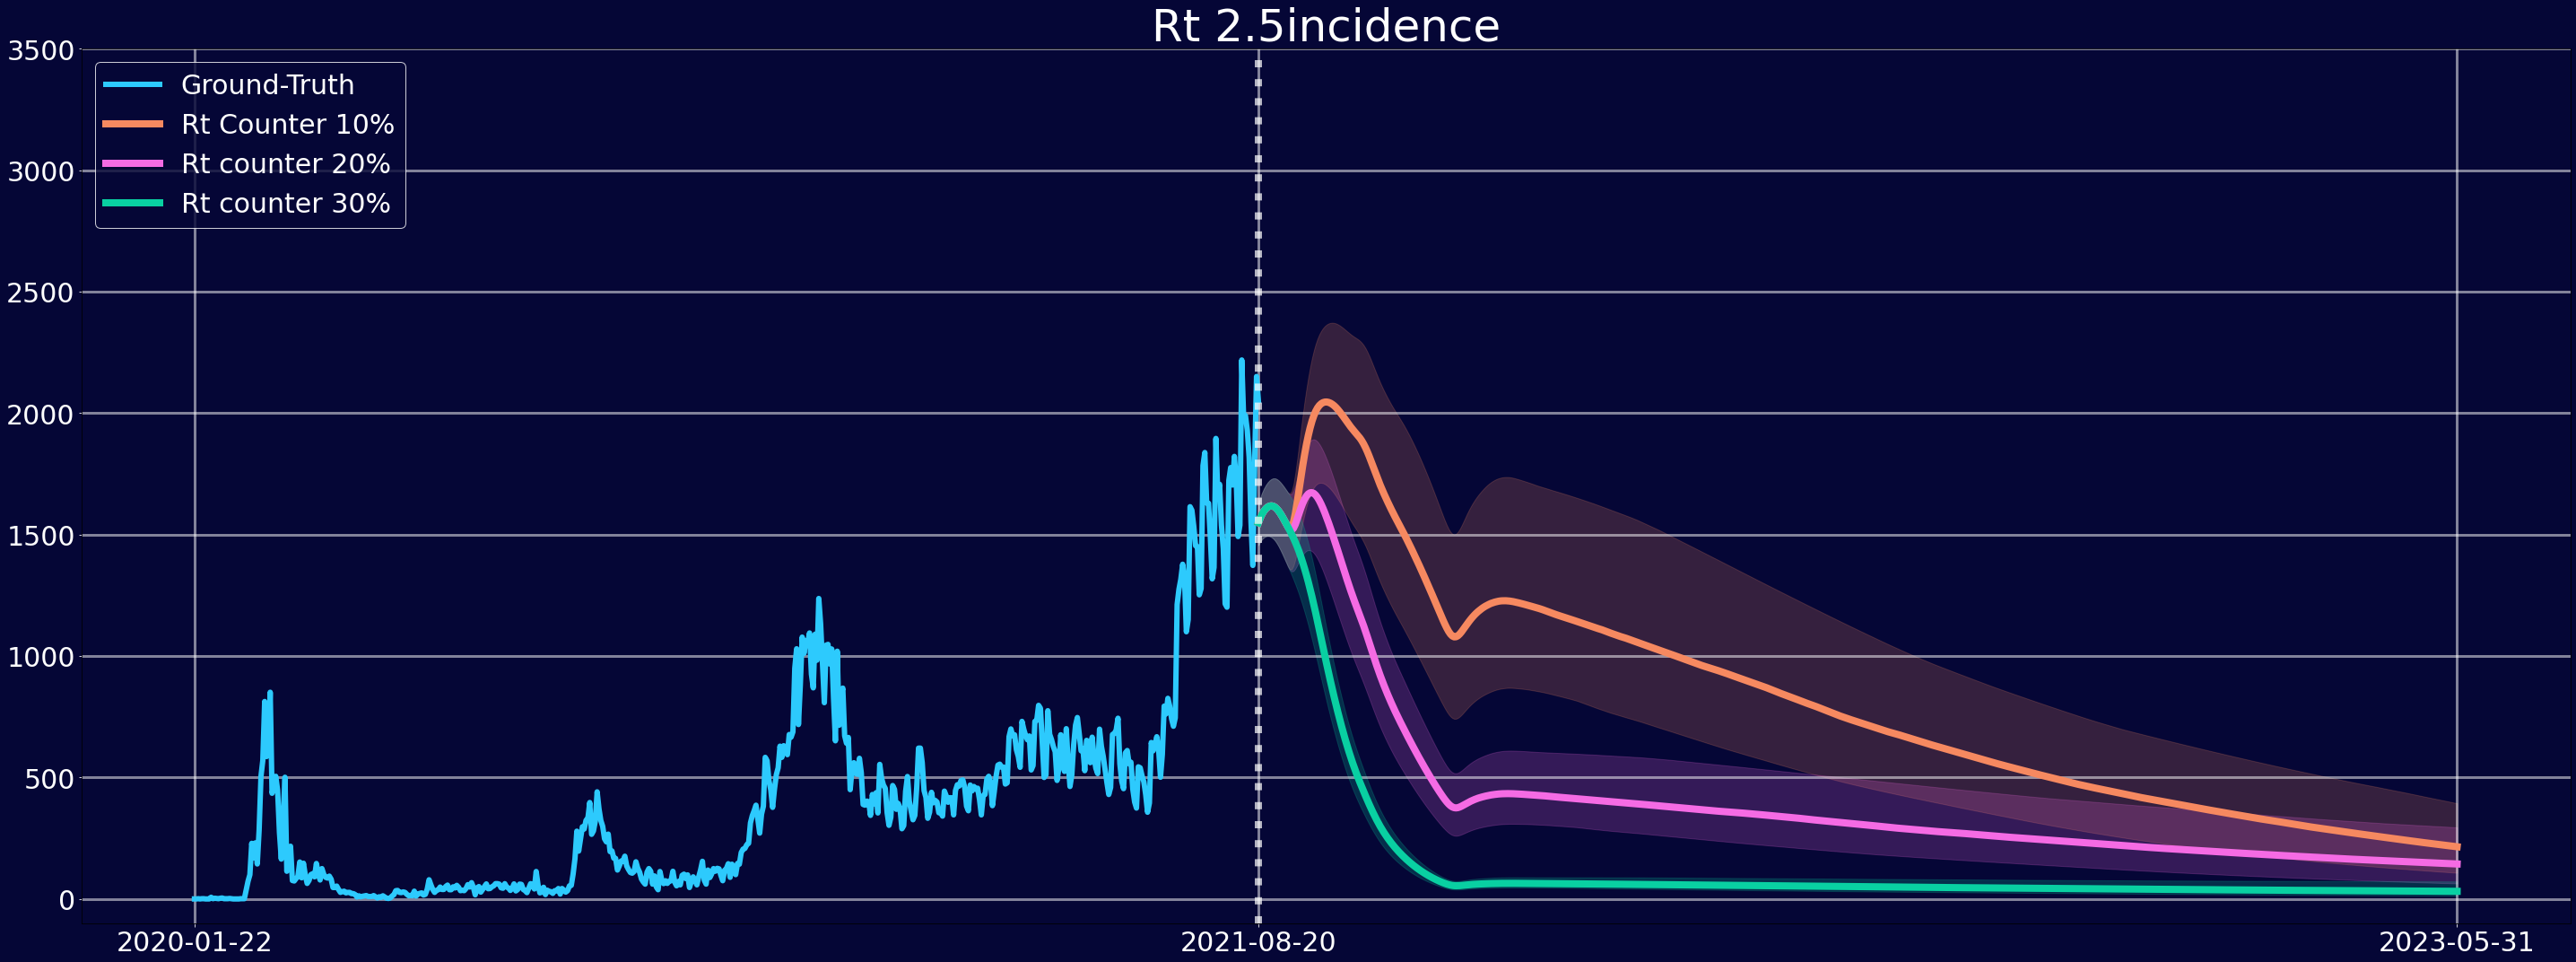

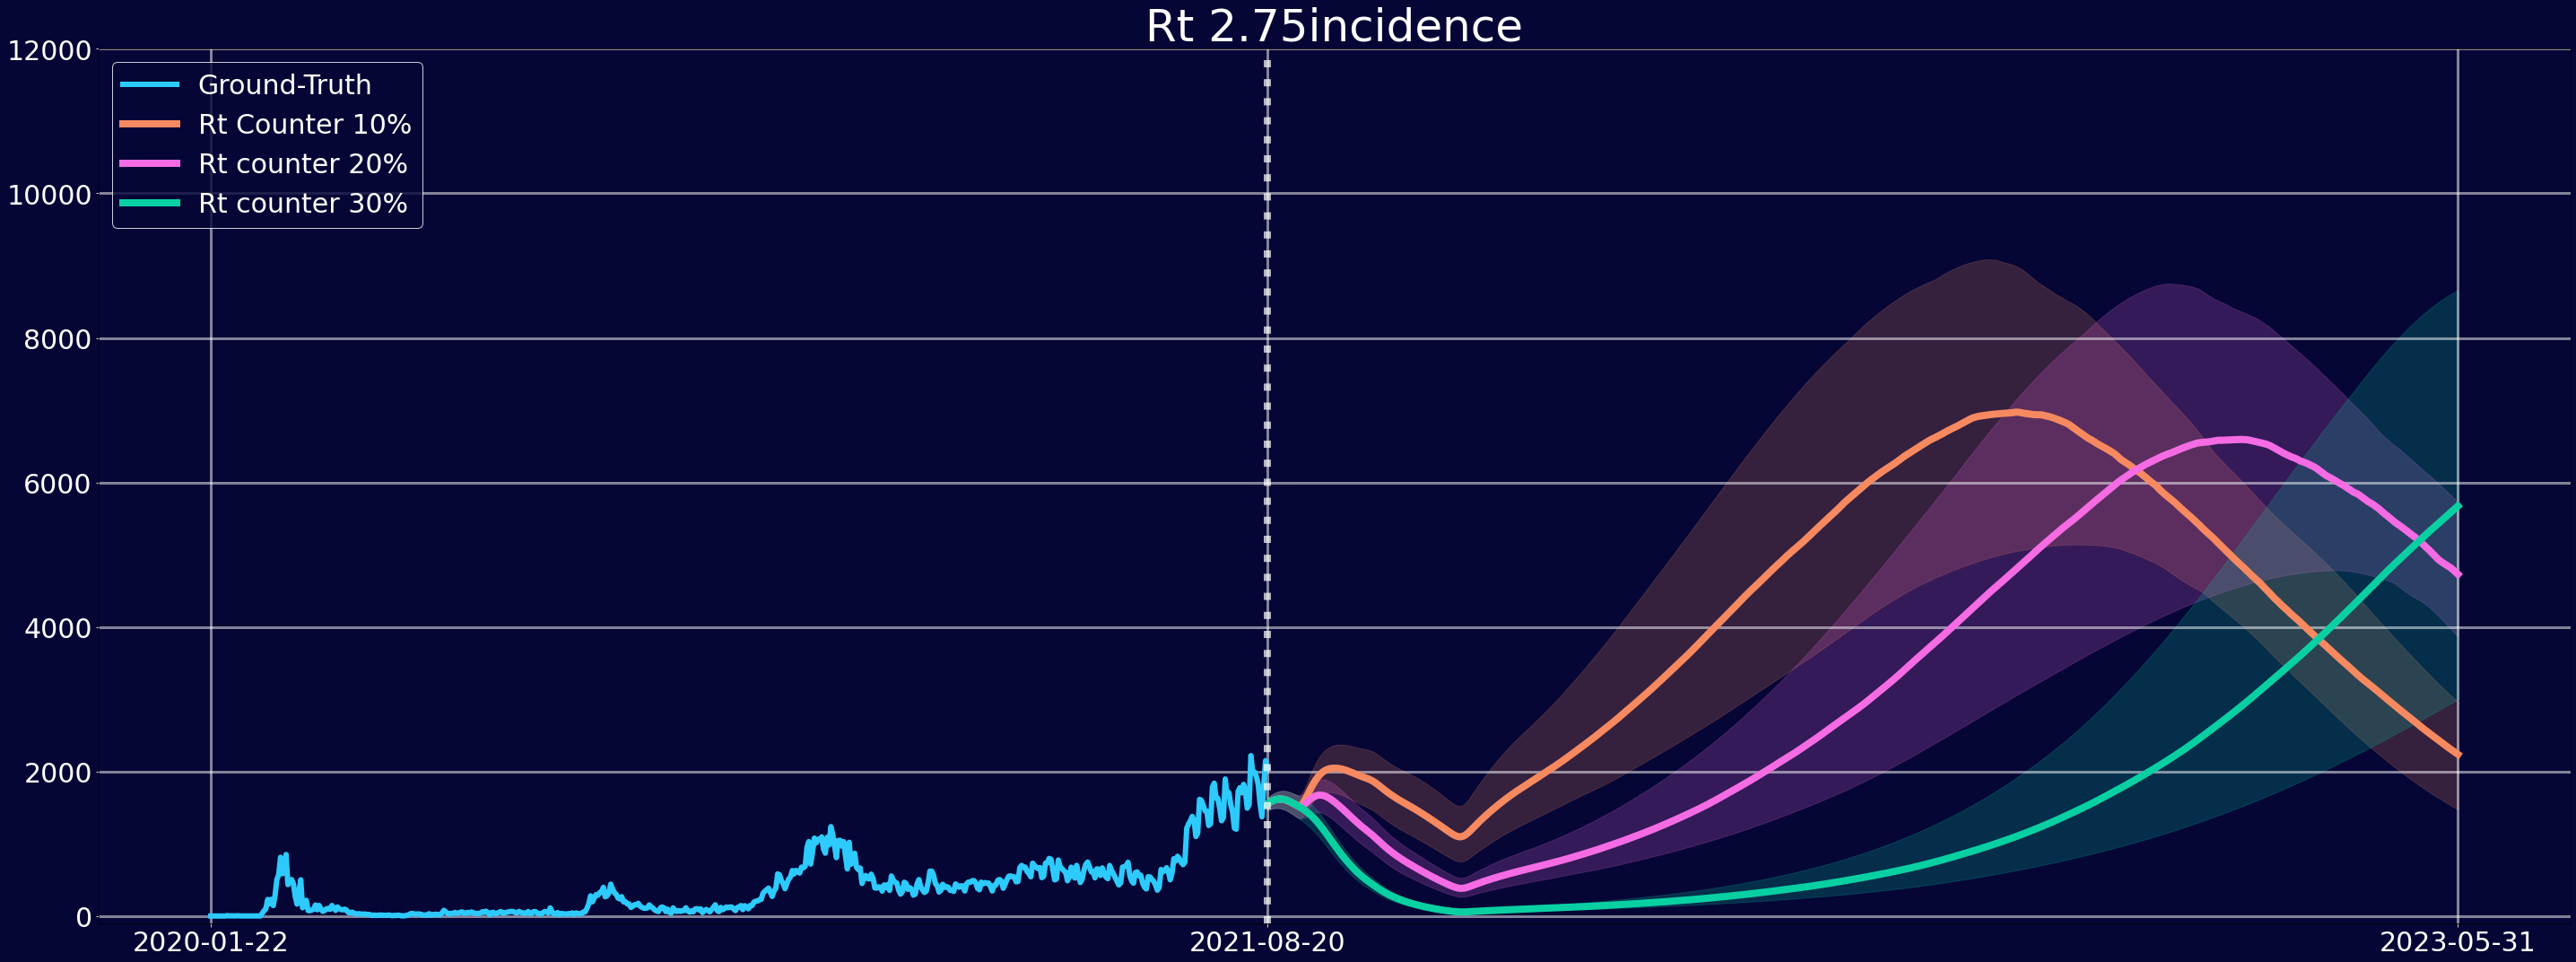

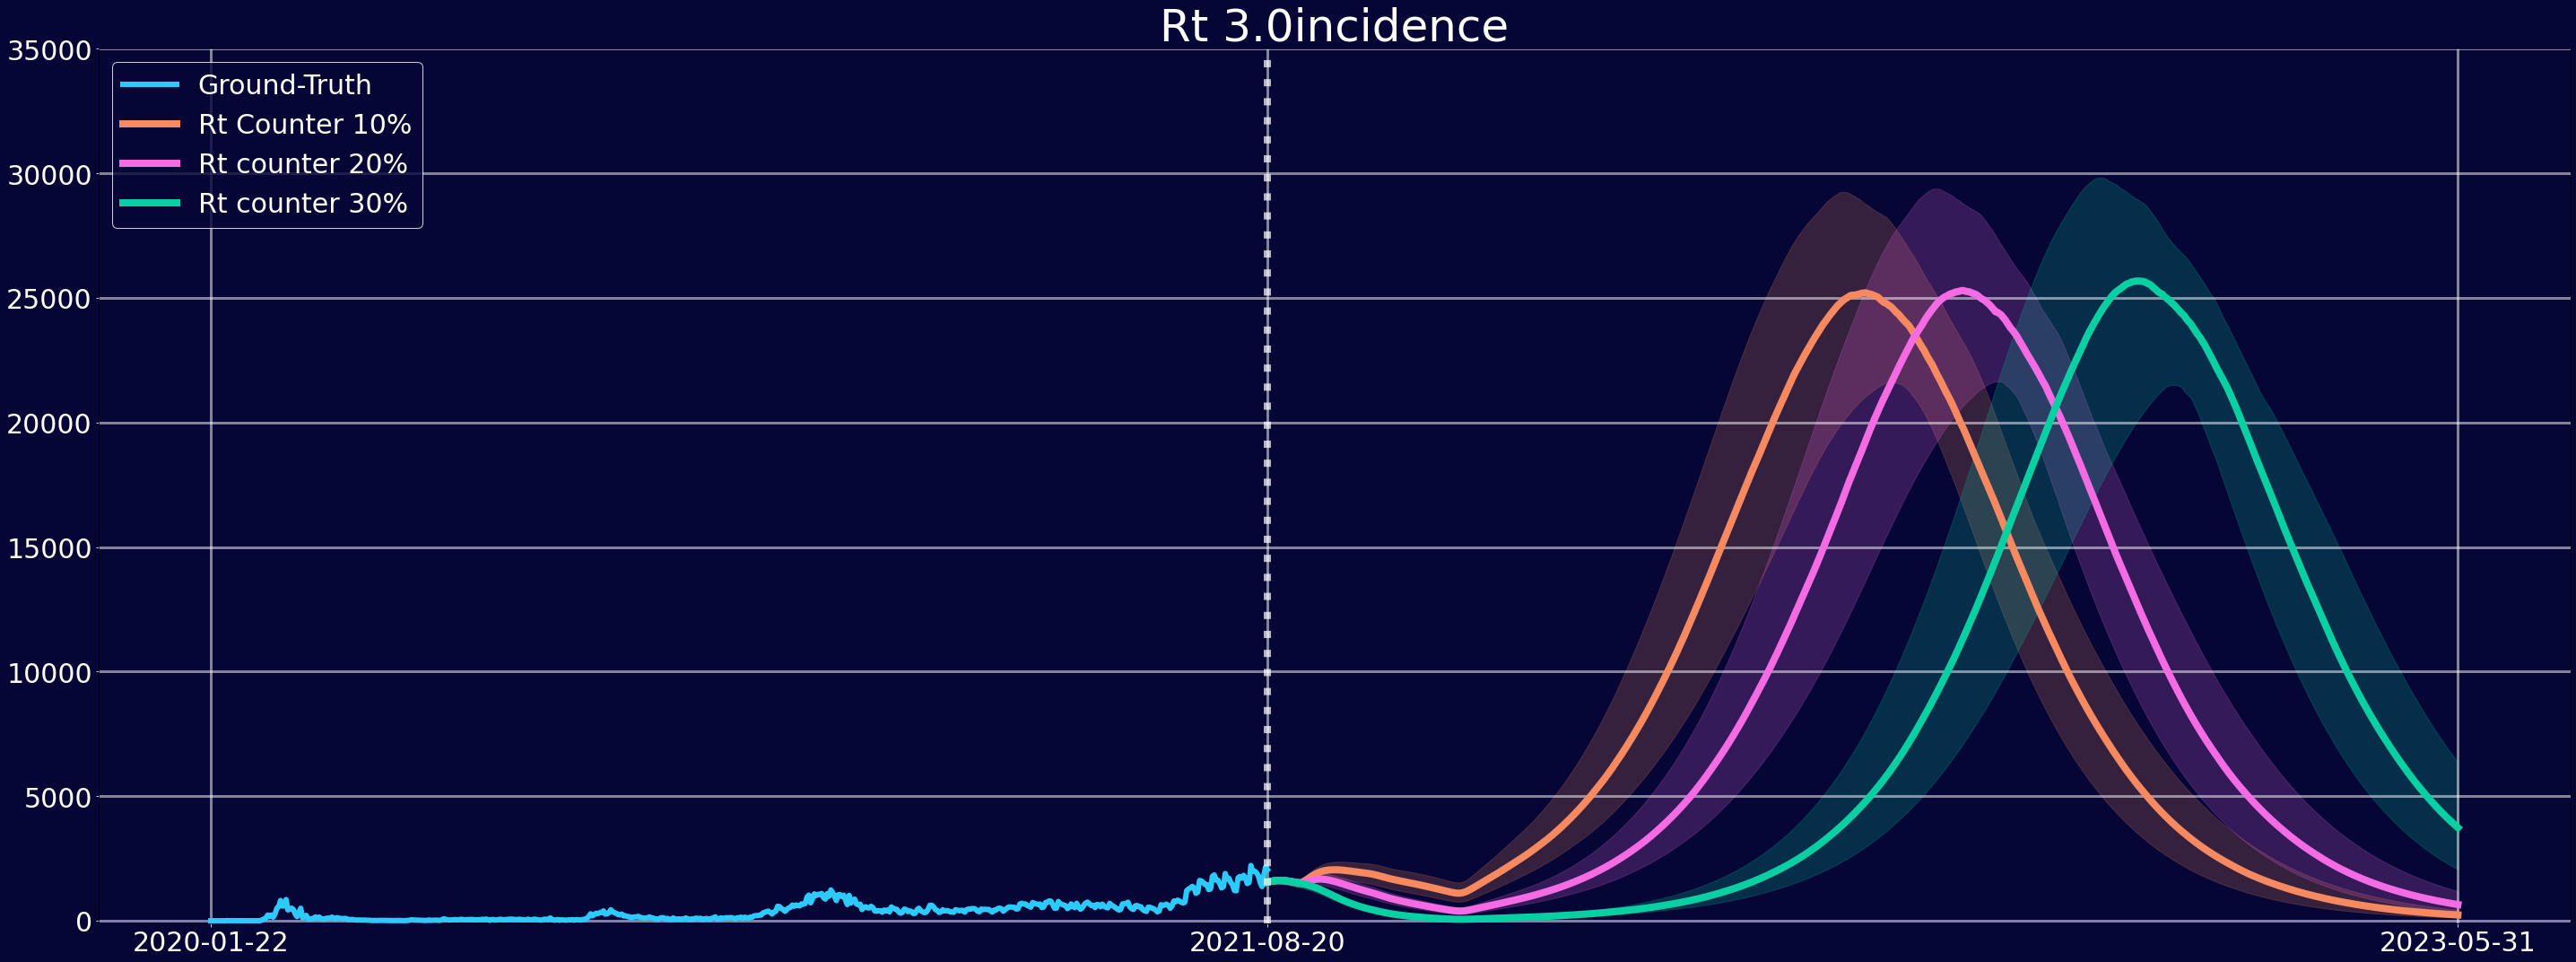

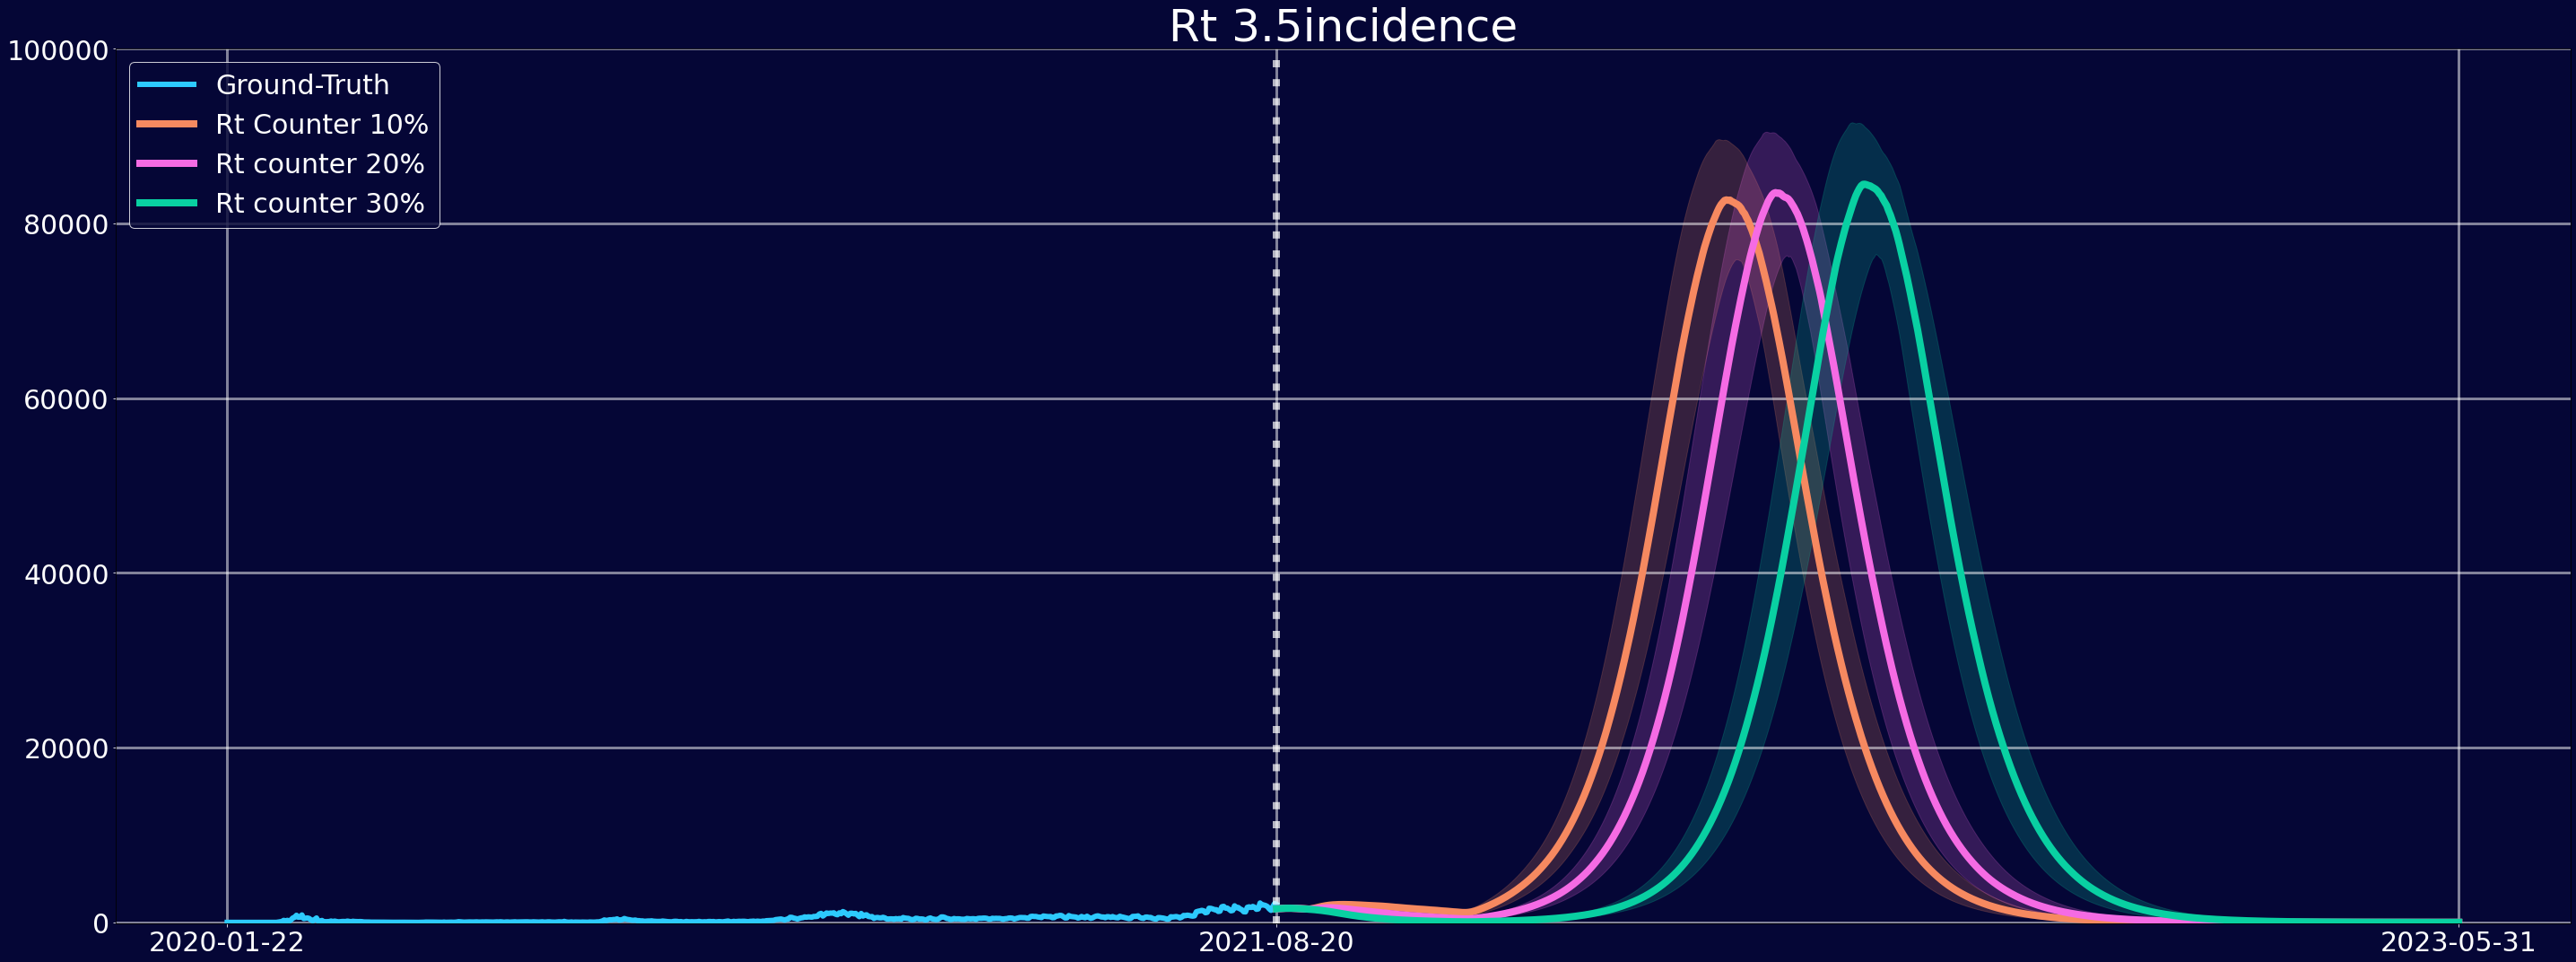

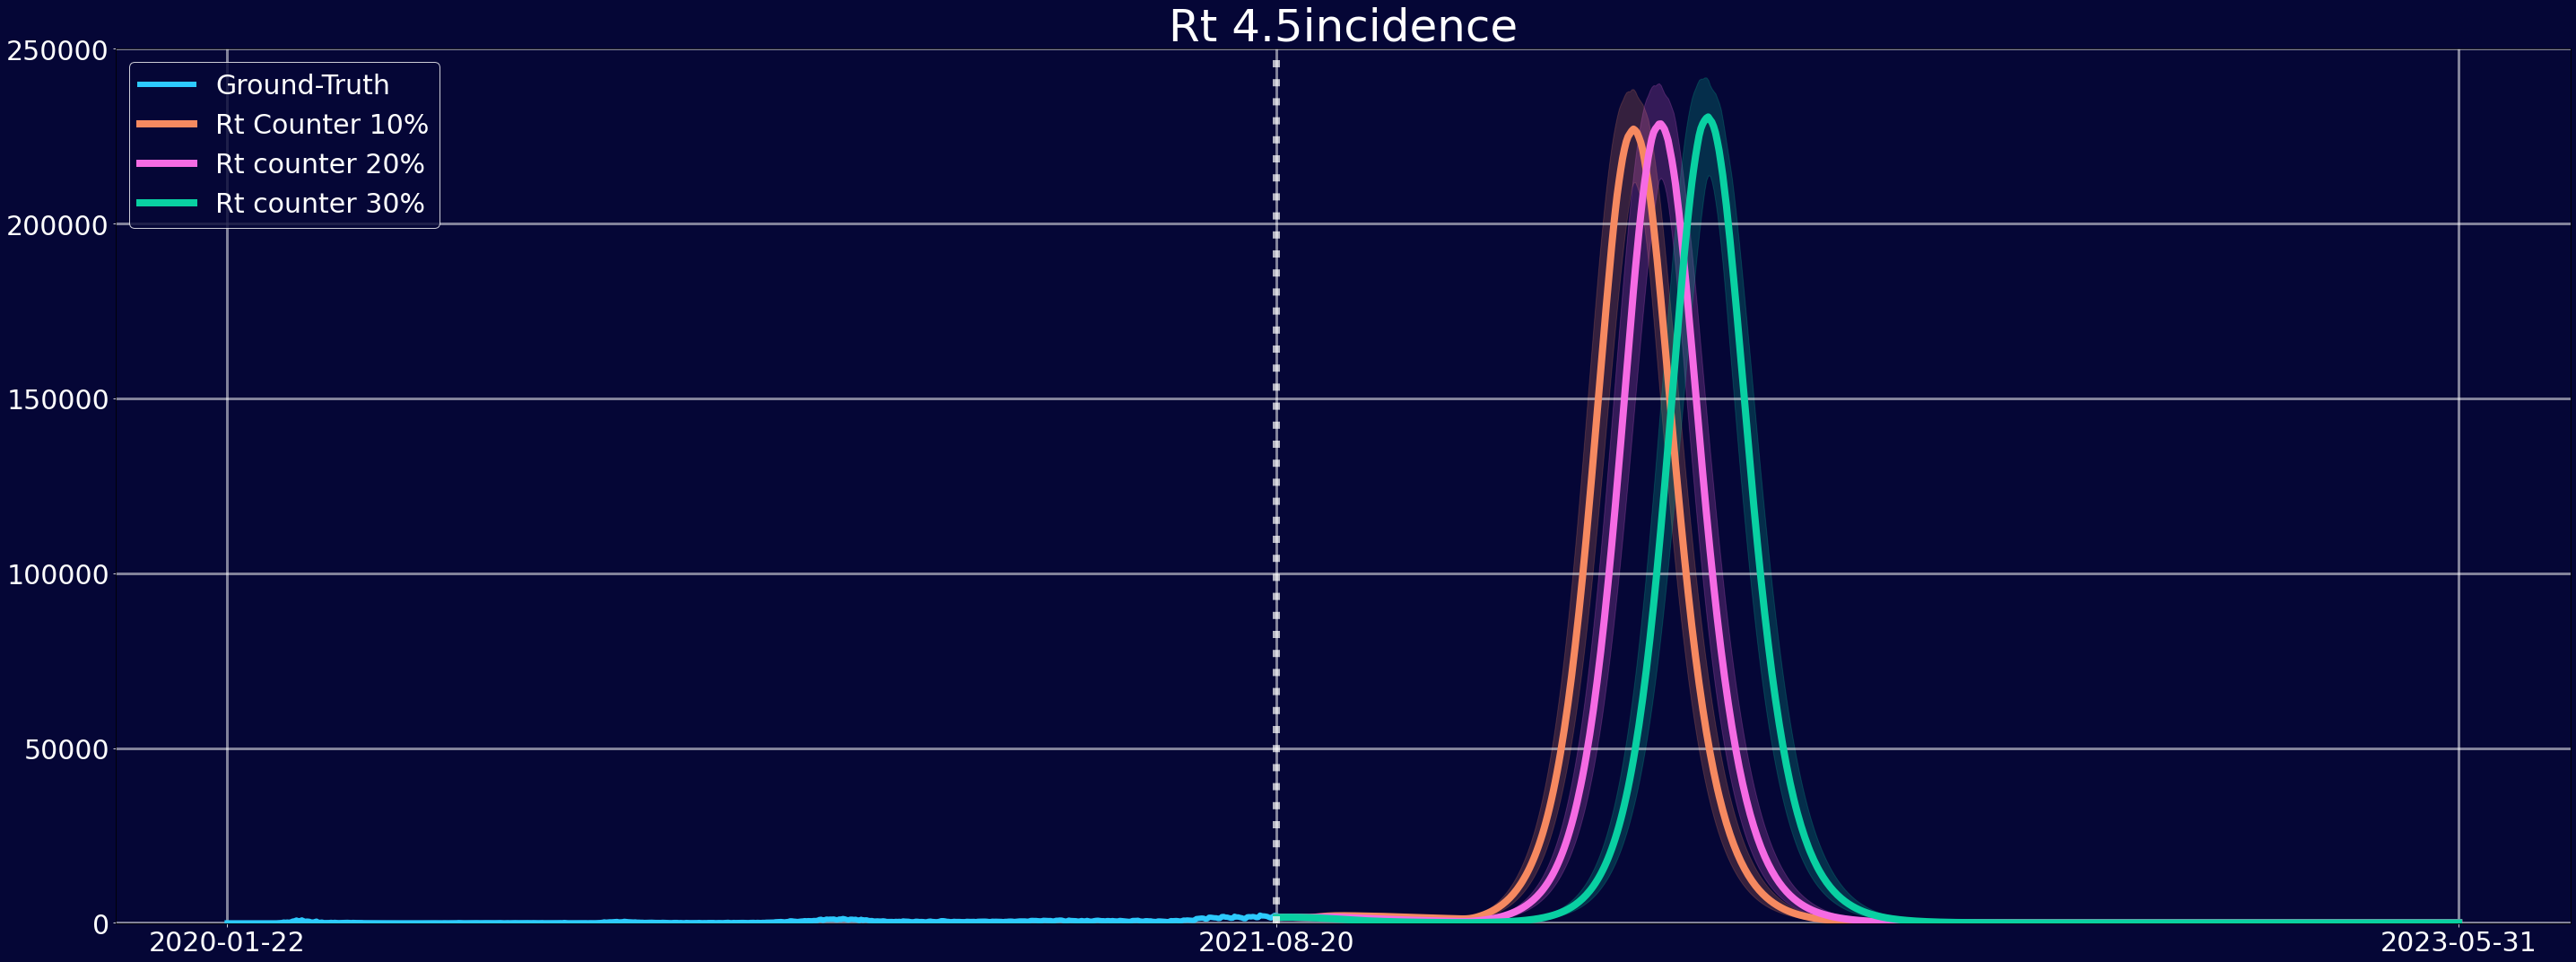

In [24]:
# rt_0_case = rt_0_case[rt_0_case['Date']>=pre_date]
# rt_1_case = rt_1_case[rt_1_case['Date']>=pre_date]
# rt_2_case = rt_2_case[rt_2_case['Date']>=pre_date]
# rt_3_case = rt_3_case[rt_3_case['Date']>=pre_date]
# rt_4_case = rt_4_case[rt_4_case['Date']>=pre_date]
Original_Plot('incidence',rt_0_case,Rt[0])
Original_Plot('incidence',rt_1_case,Rt[1])
Original_Plot('incidence',rt_2_case,Rt[2])
Original_Plot('incidence',rt_3_case,Rt[3])
Original_Plot('incidence',rt_4_case,Rt[4])

### 중증자

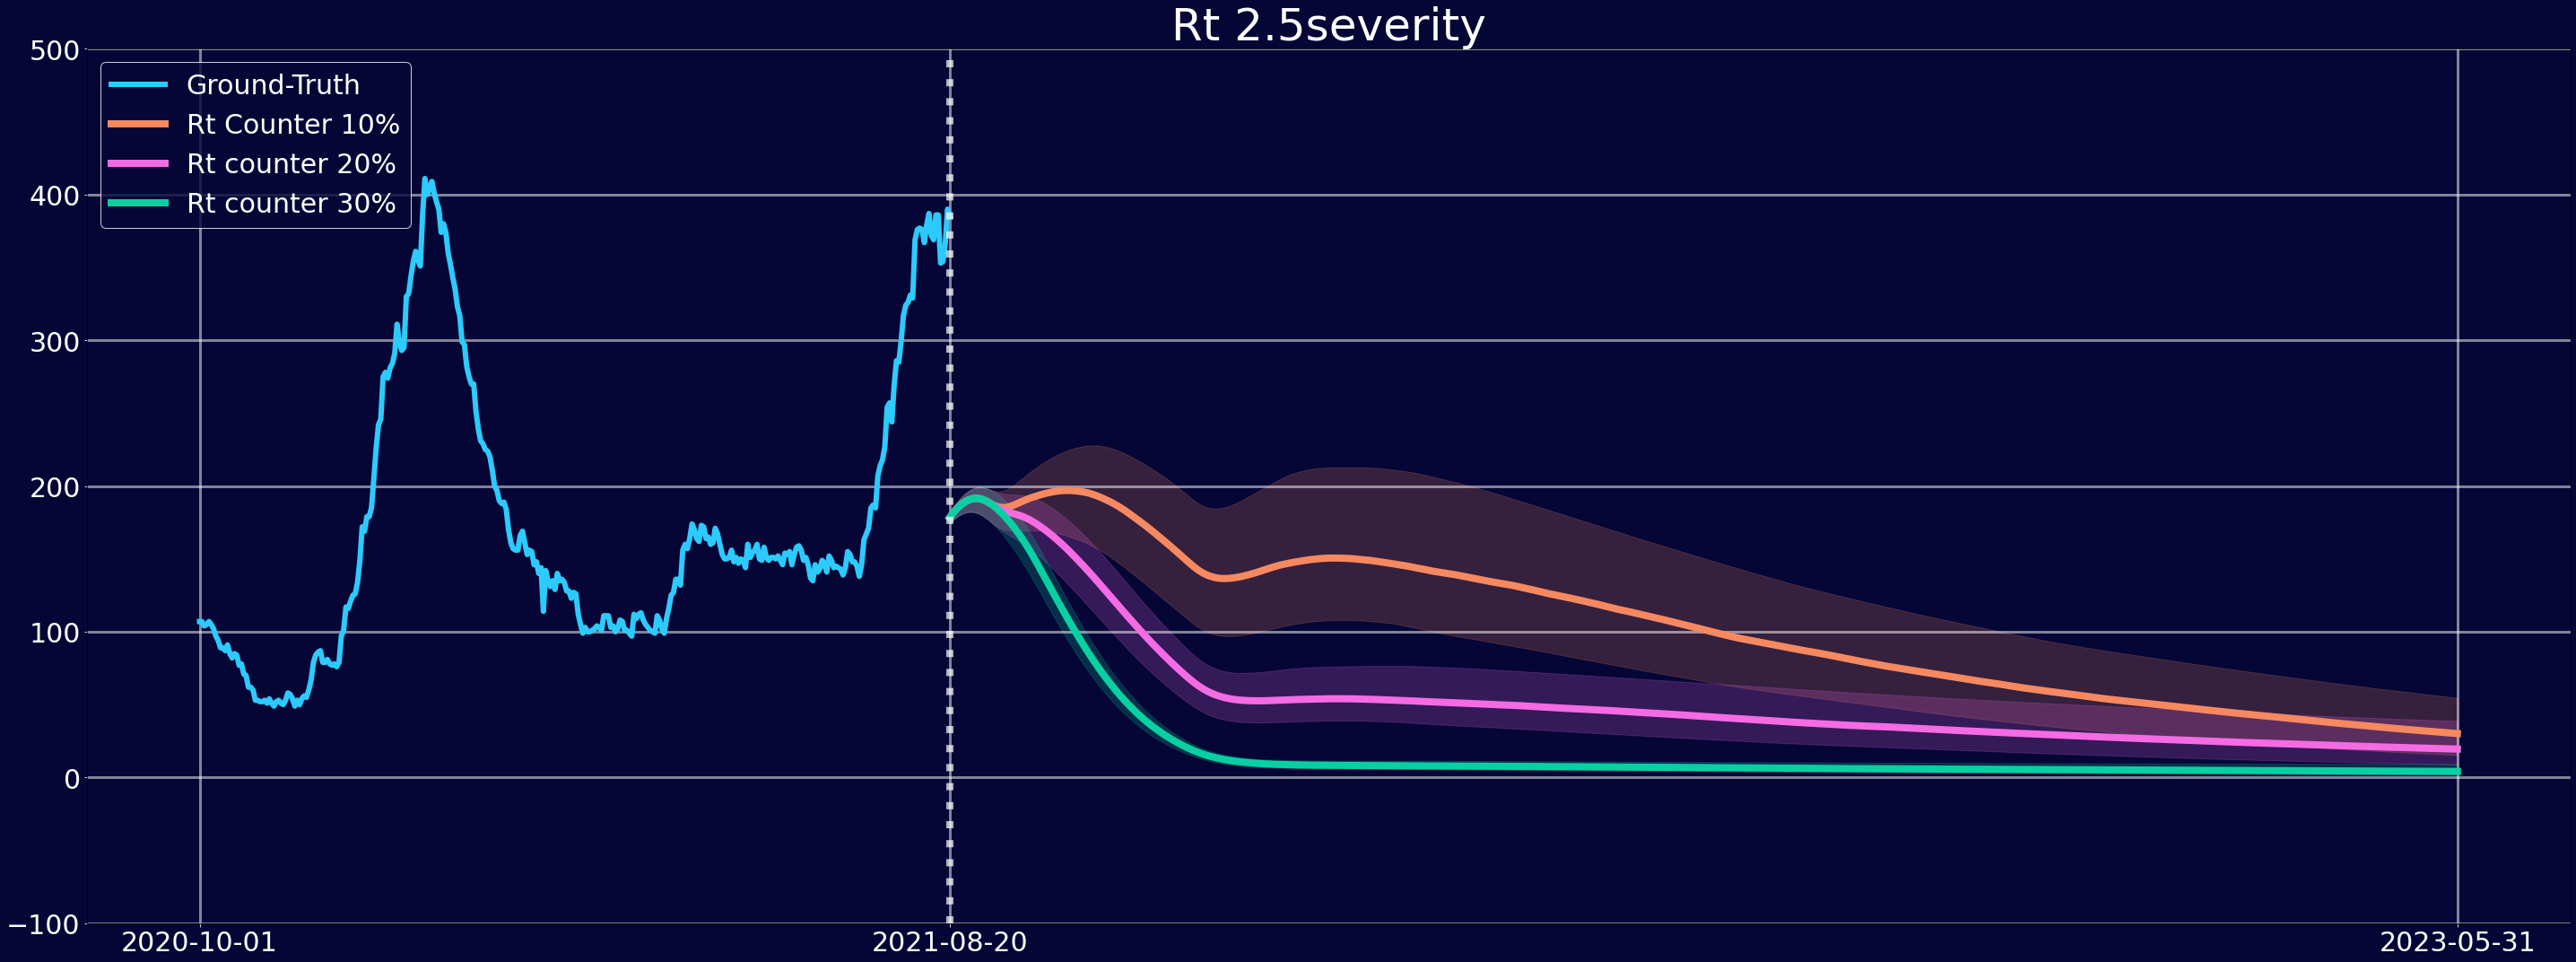

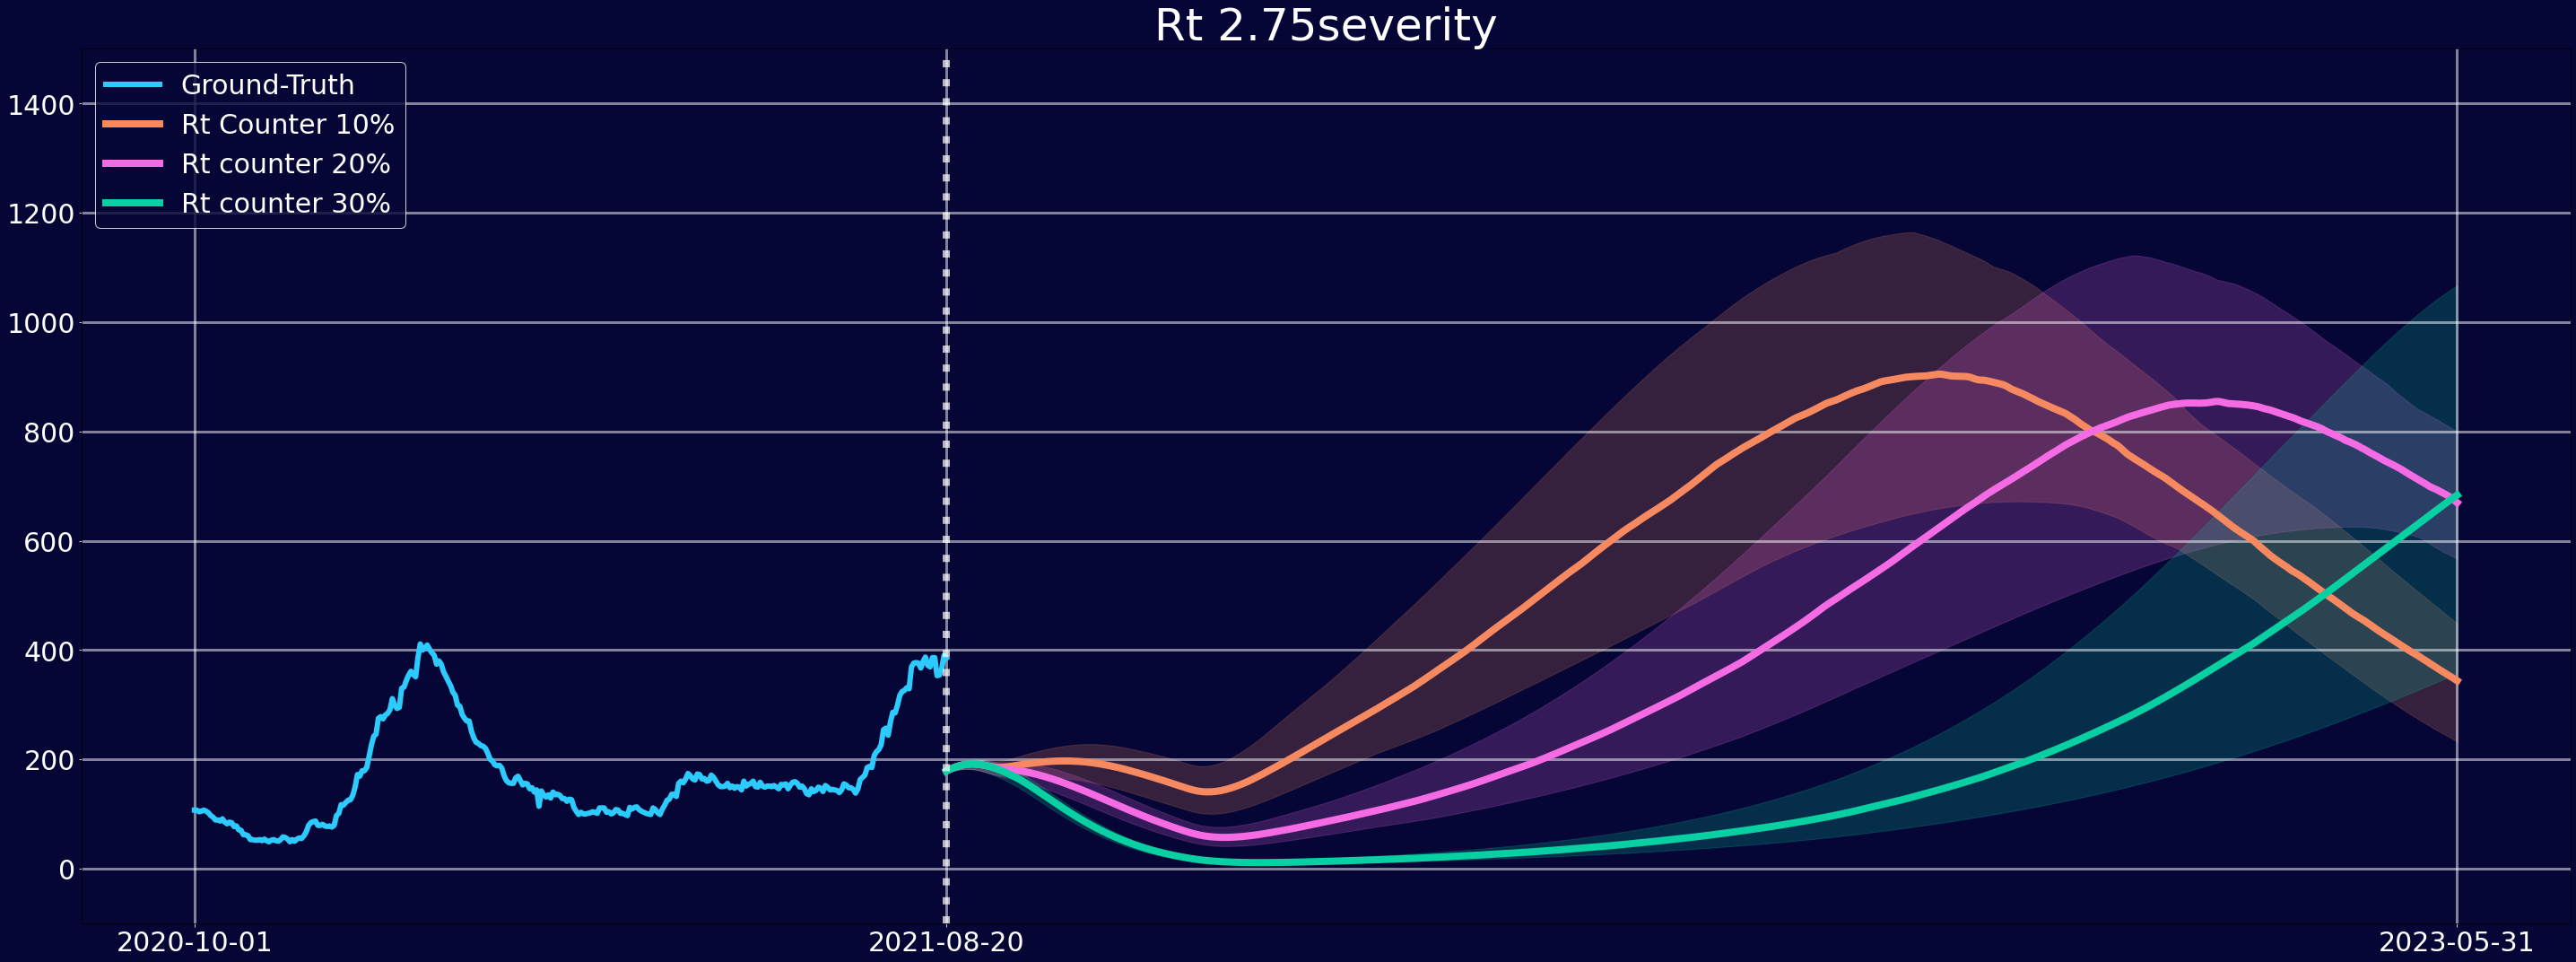

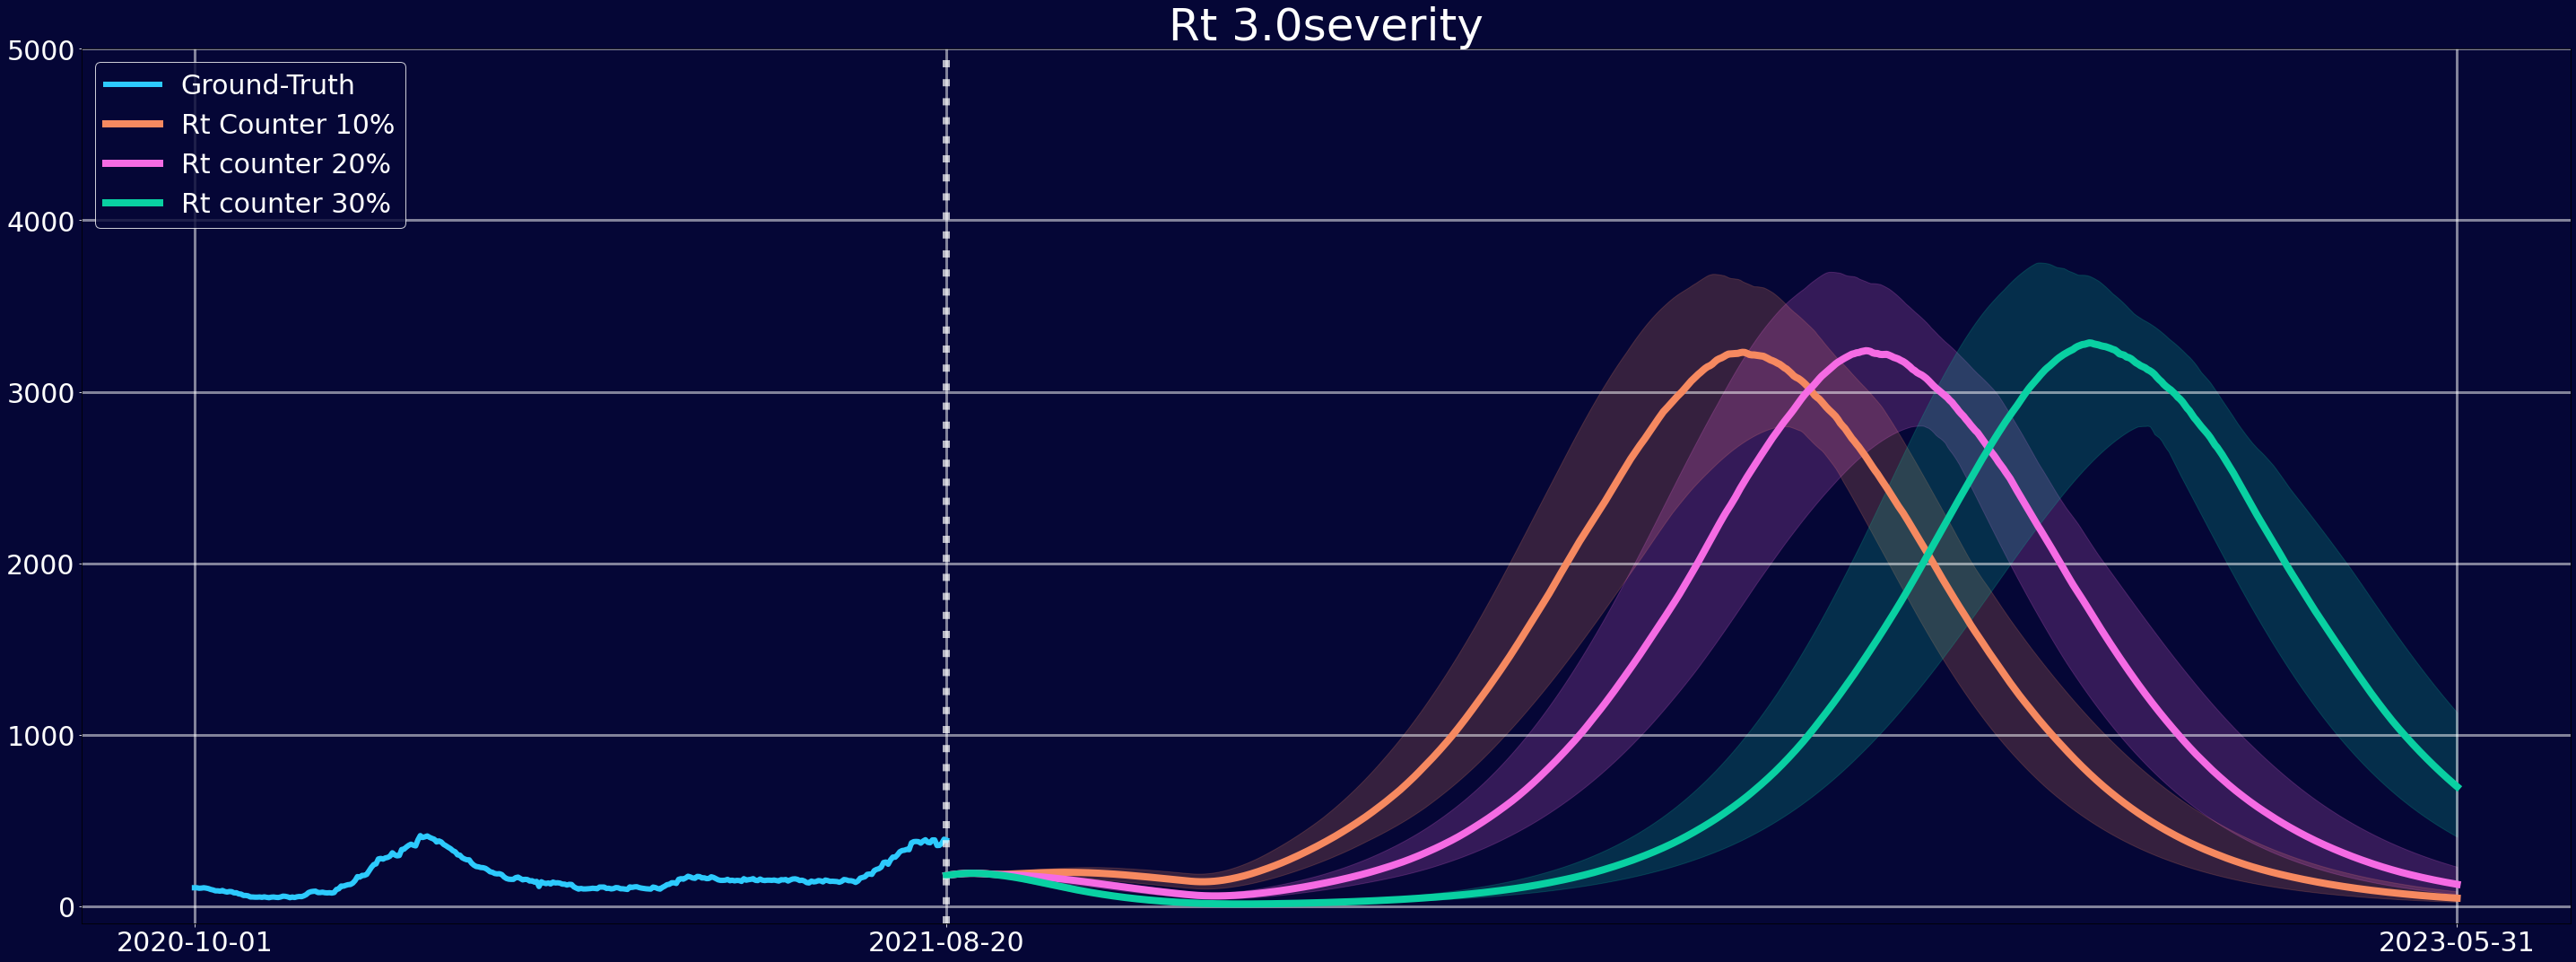

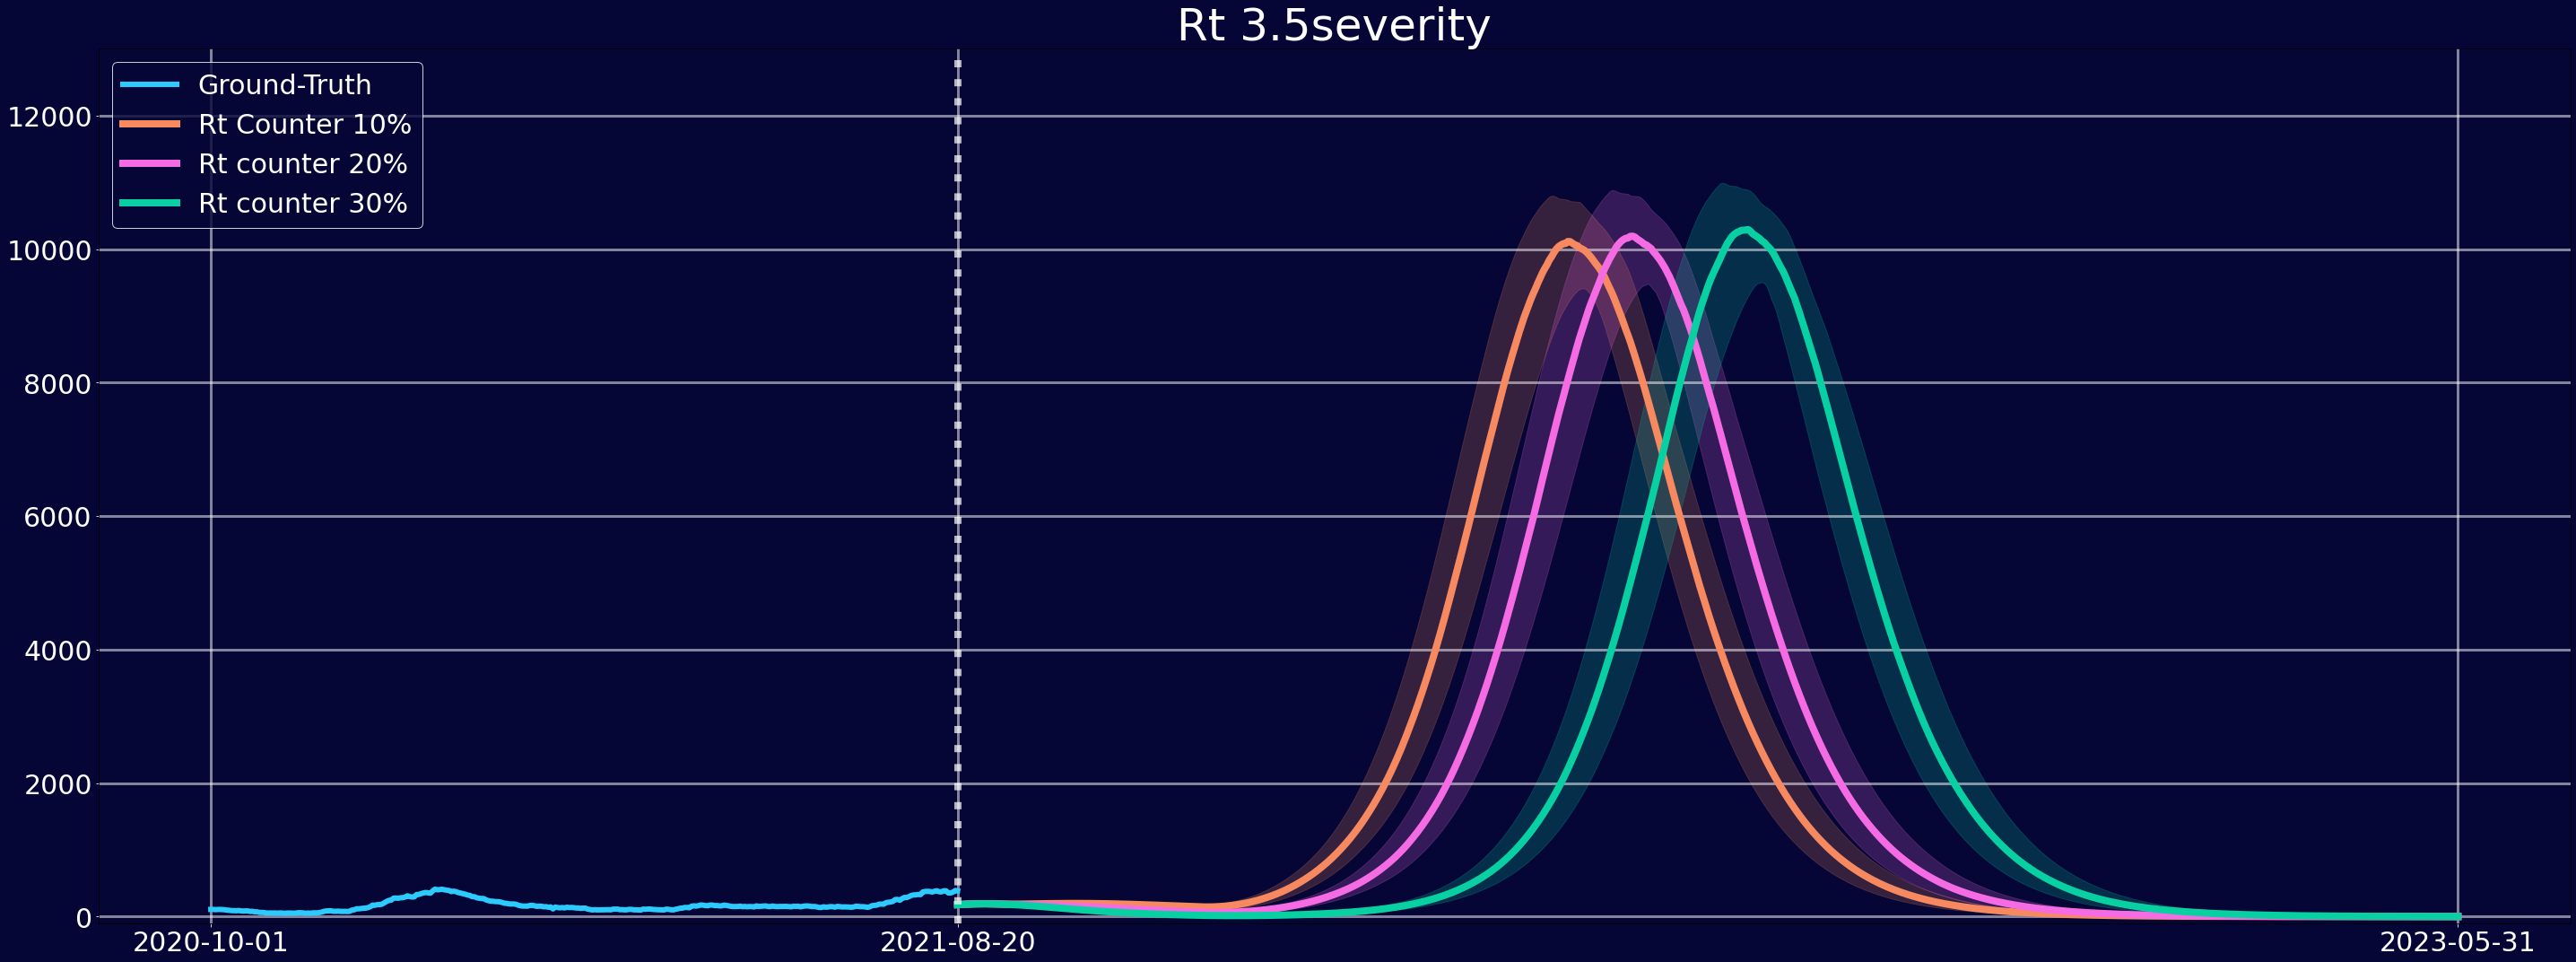

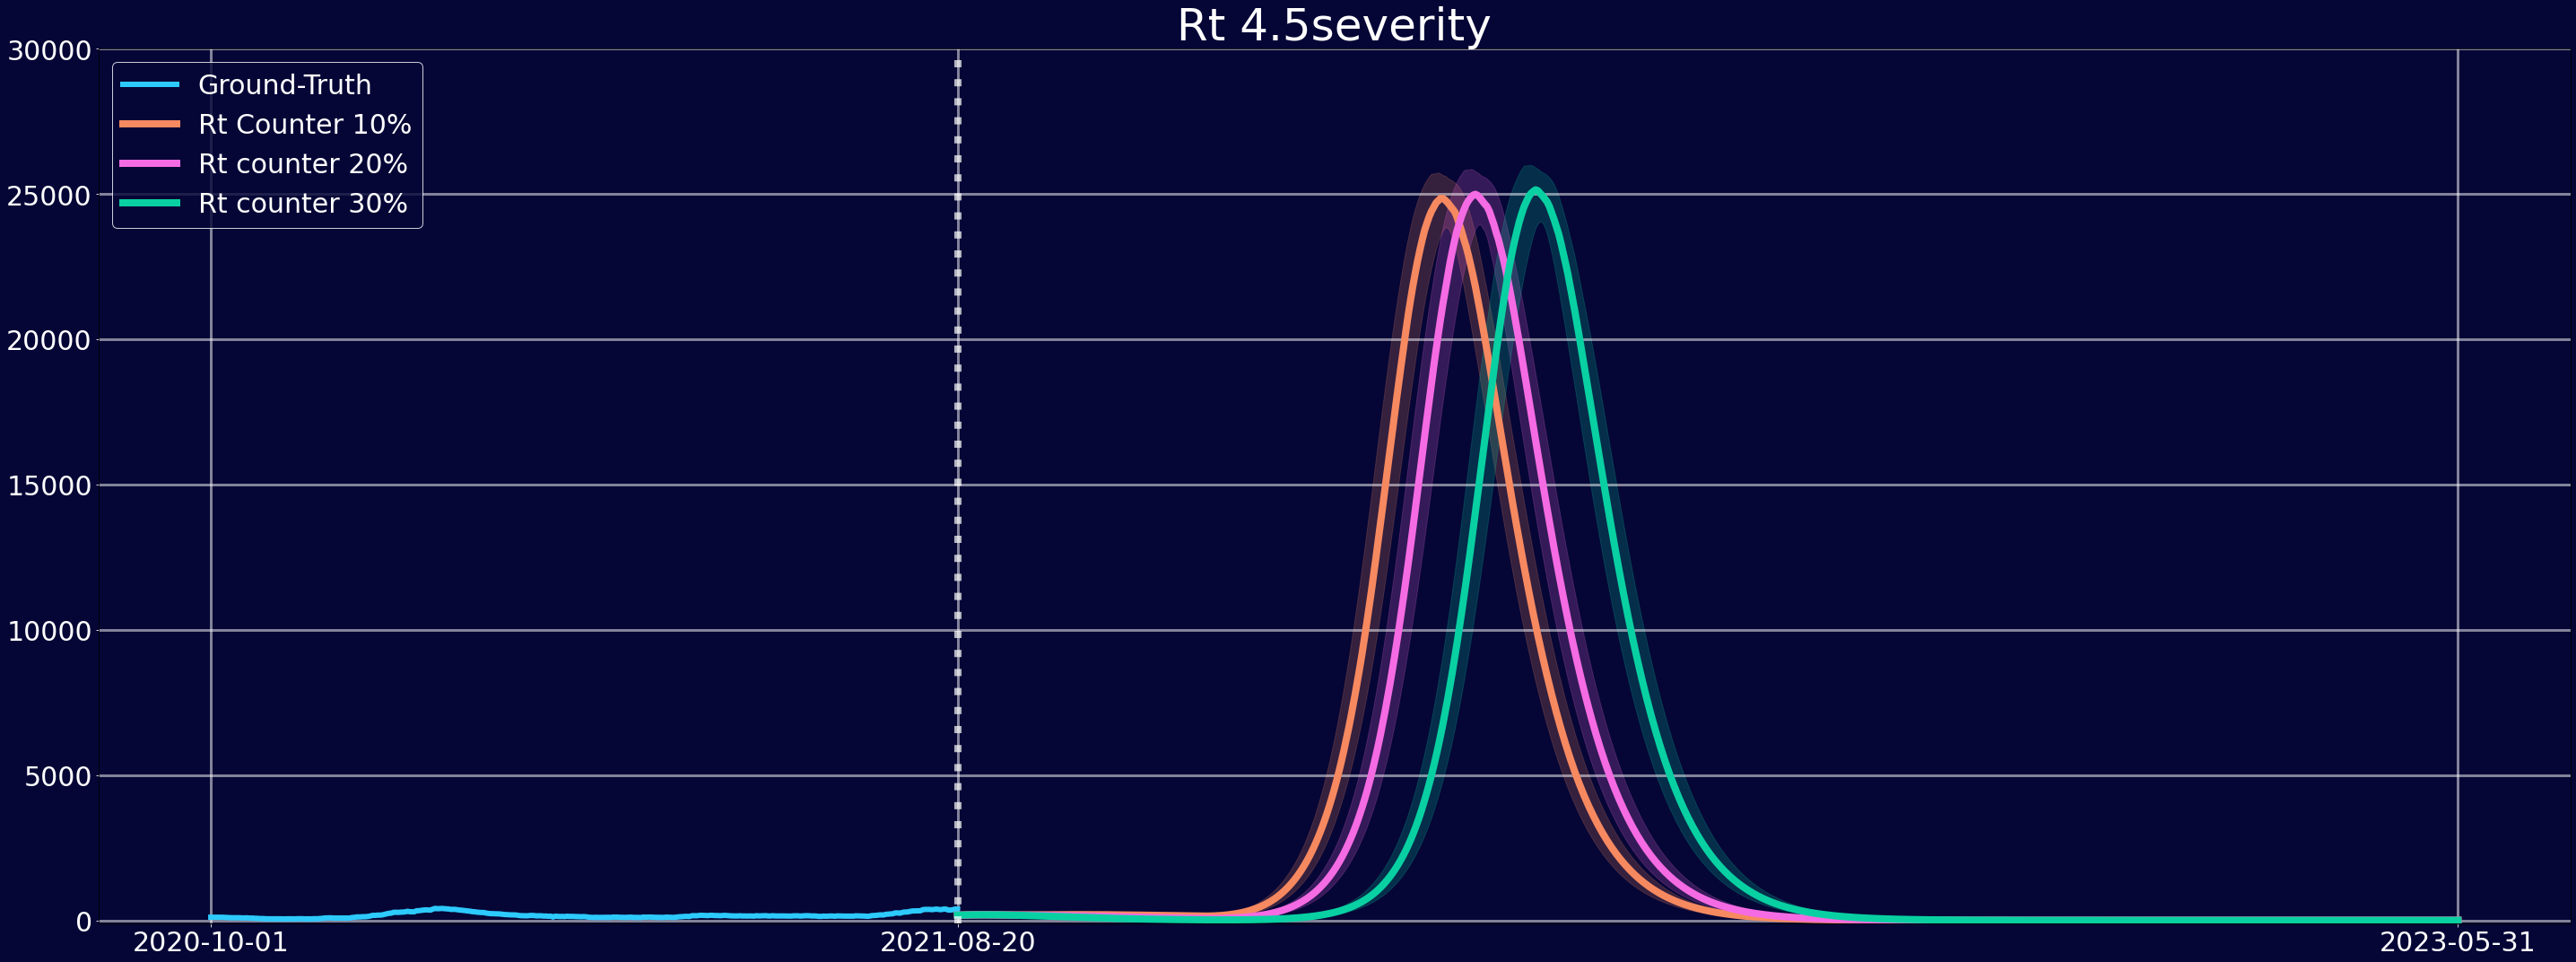

In [25]:
# rt_0_serve = rt_0_serve[rt_0_serve['Date']>=pre_date]
# rt_1_serve = rt_1_serve[rt_1_serve['Date']>=pre_date]
# rt_2_serve = rt_2_serve[rt_2_serve['Date']>=pre_date]
# rt_3_serve = rt_3_serve[rt_3_serve['Date']>=pre_date]
# rt_4_serve = rt_4_serve[rt_4_serve['Date']>=pre_date]
Original_Plot('severity',rt_0_serve,Rt[0])
Original_Plot('severity',rt_1_serve,Rt[1])
Original_Plot('severity',rt_2_serve,Rt[2])
Original_Plot('severity',rt_3_serve,Rt[3])
Original_Plot('severity',rt_4_serve,Rt[4])

### 사망자

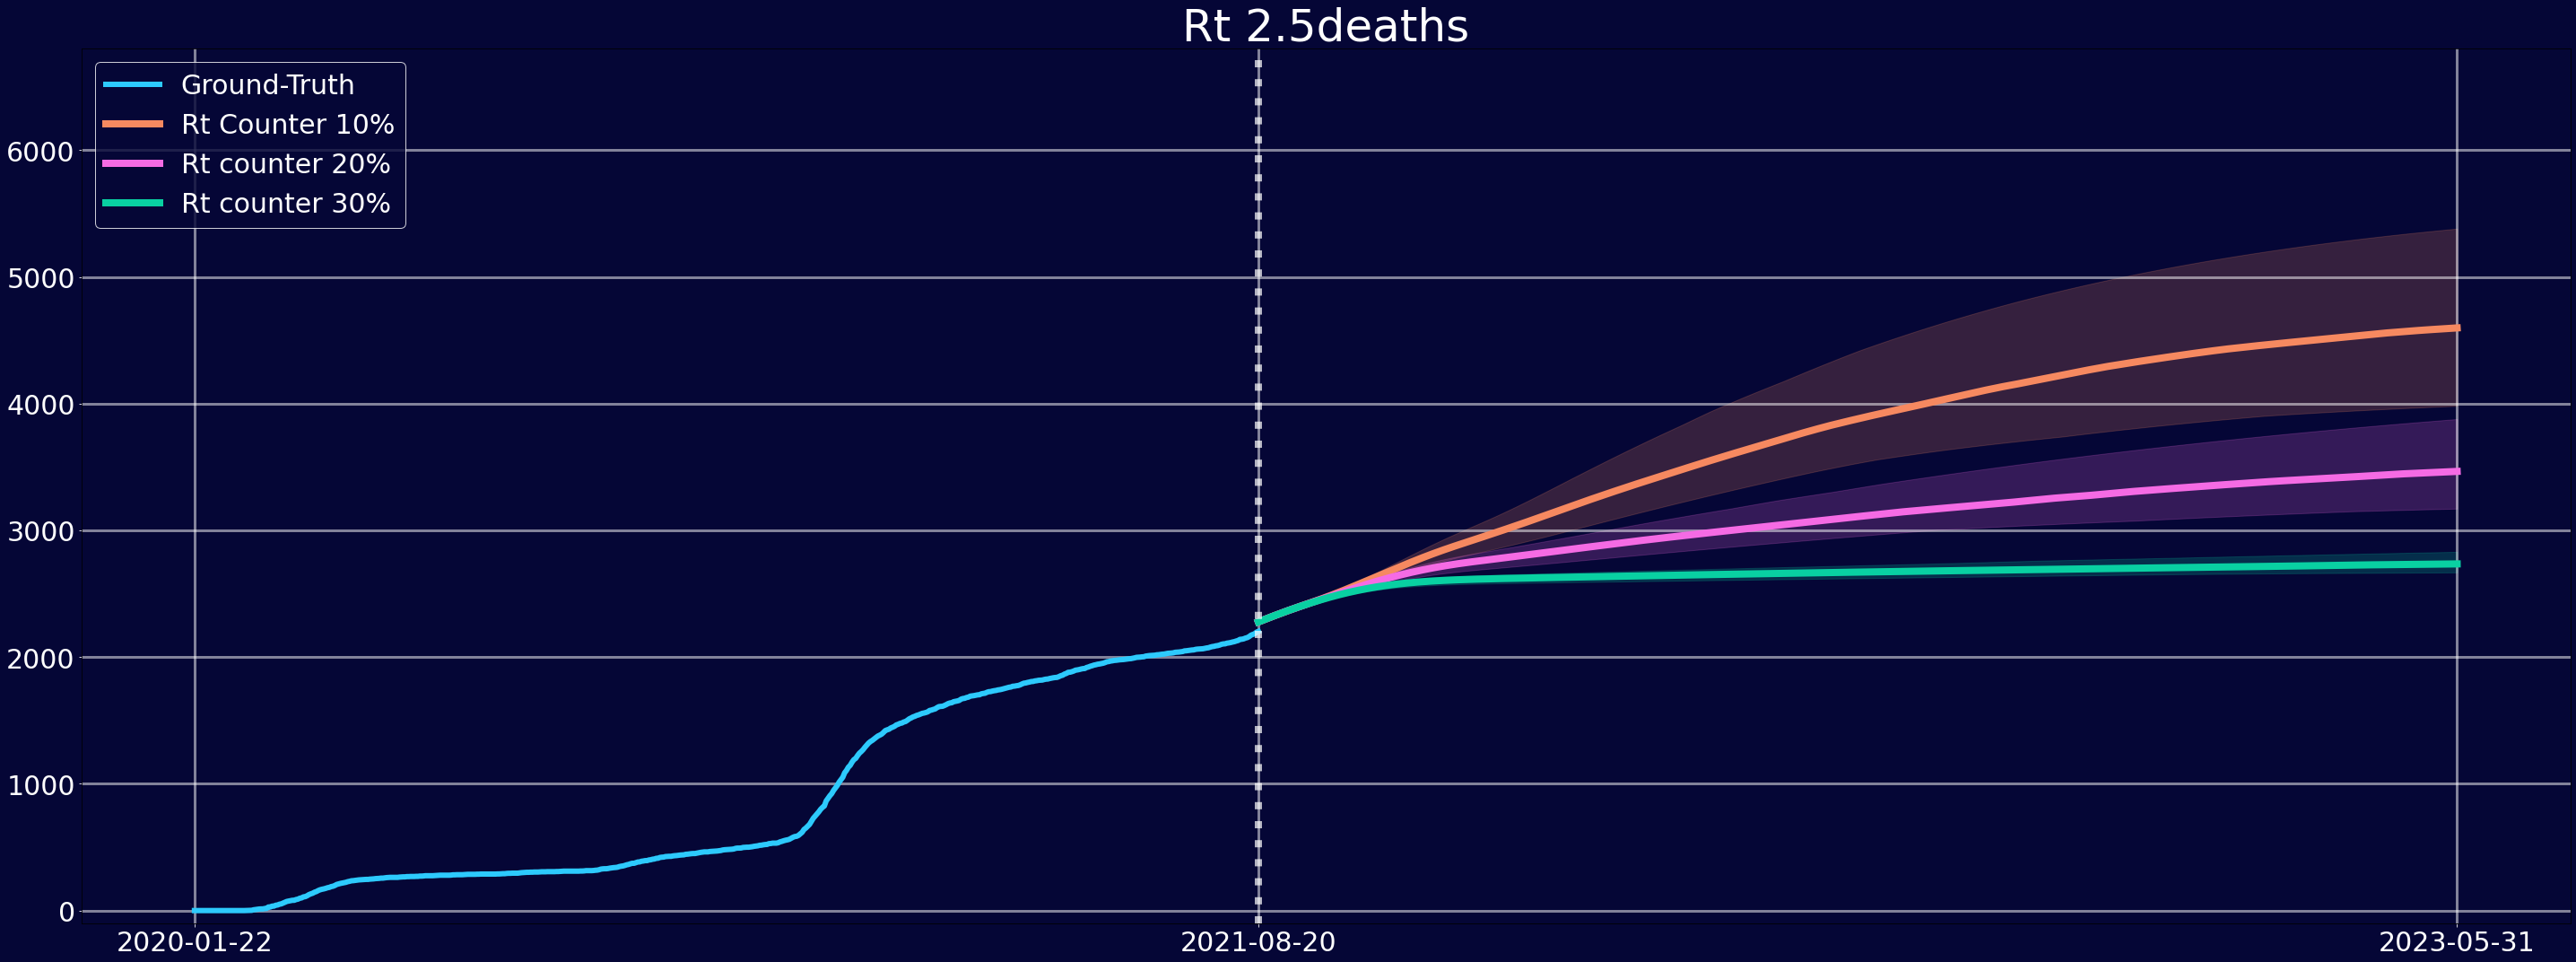

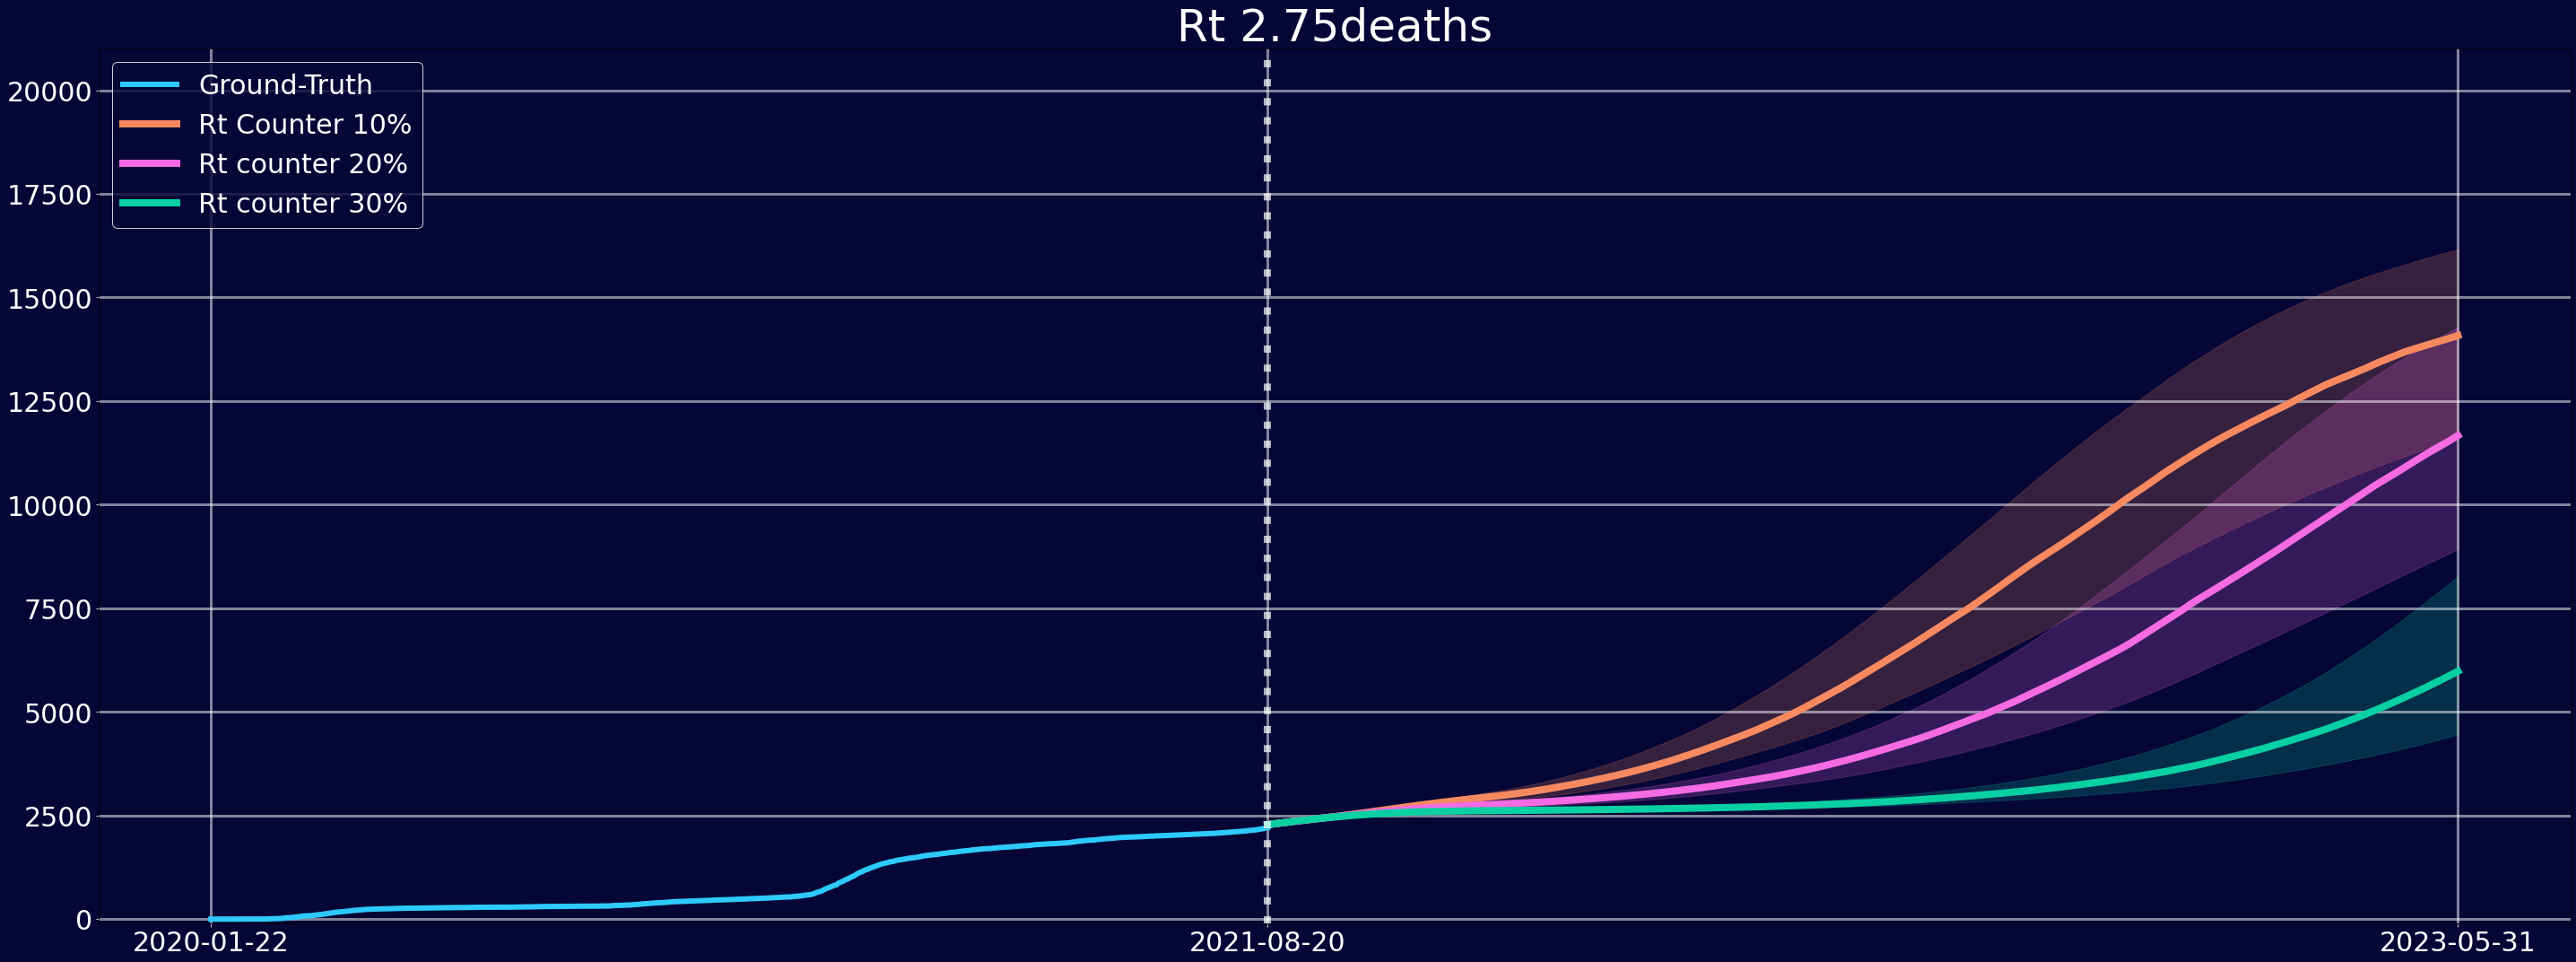

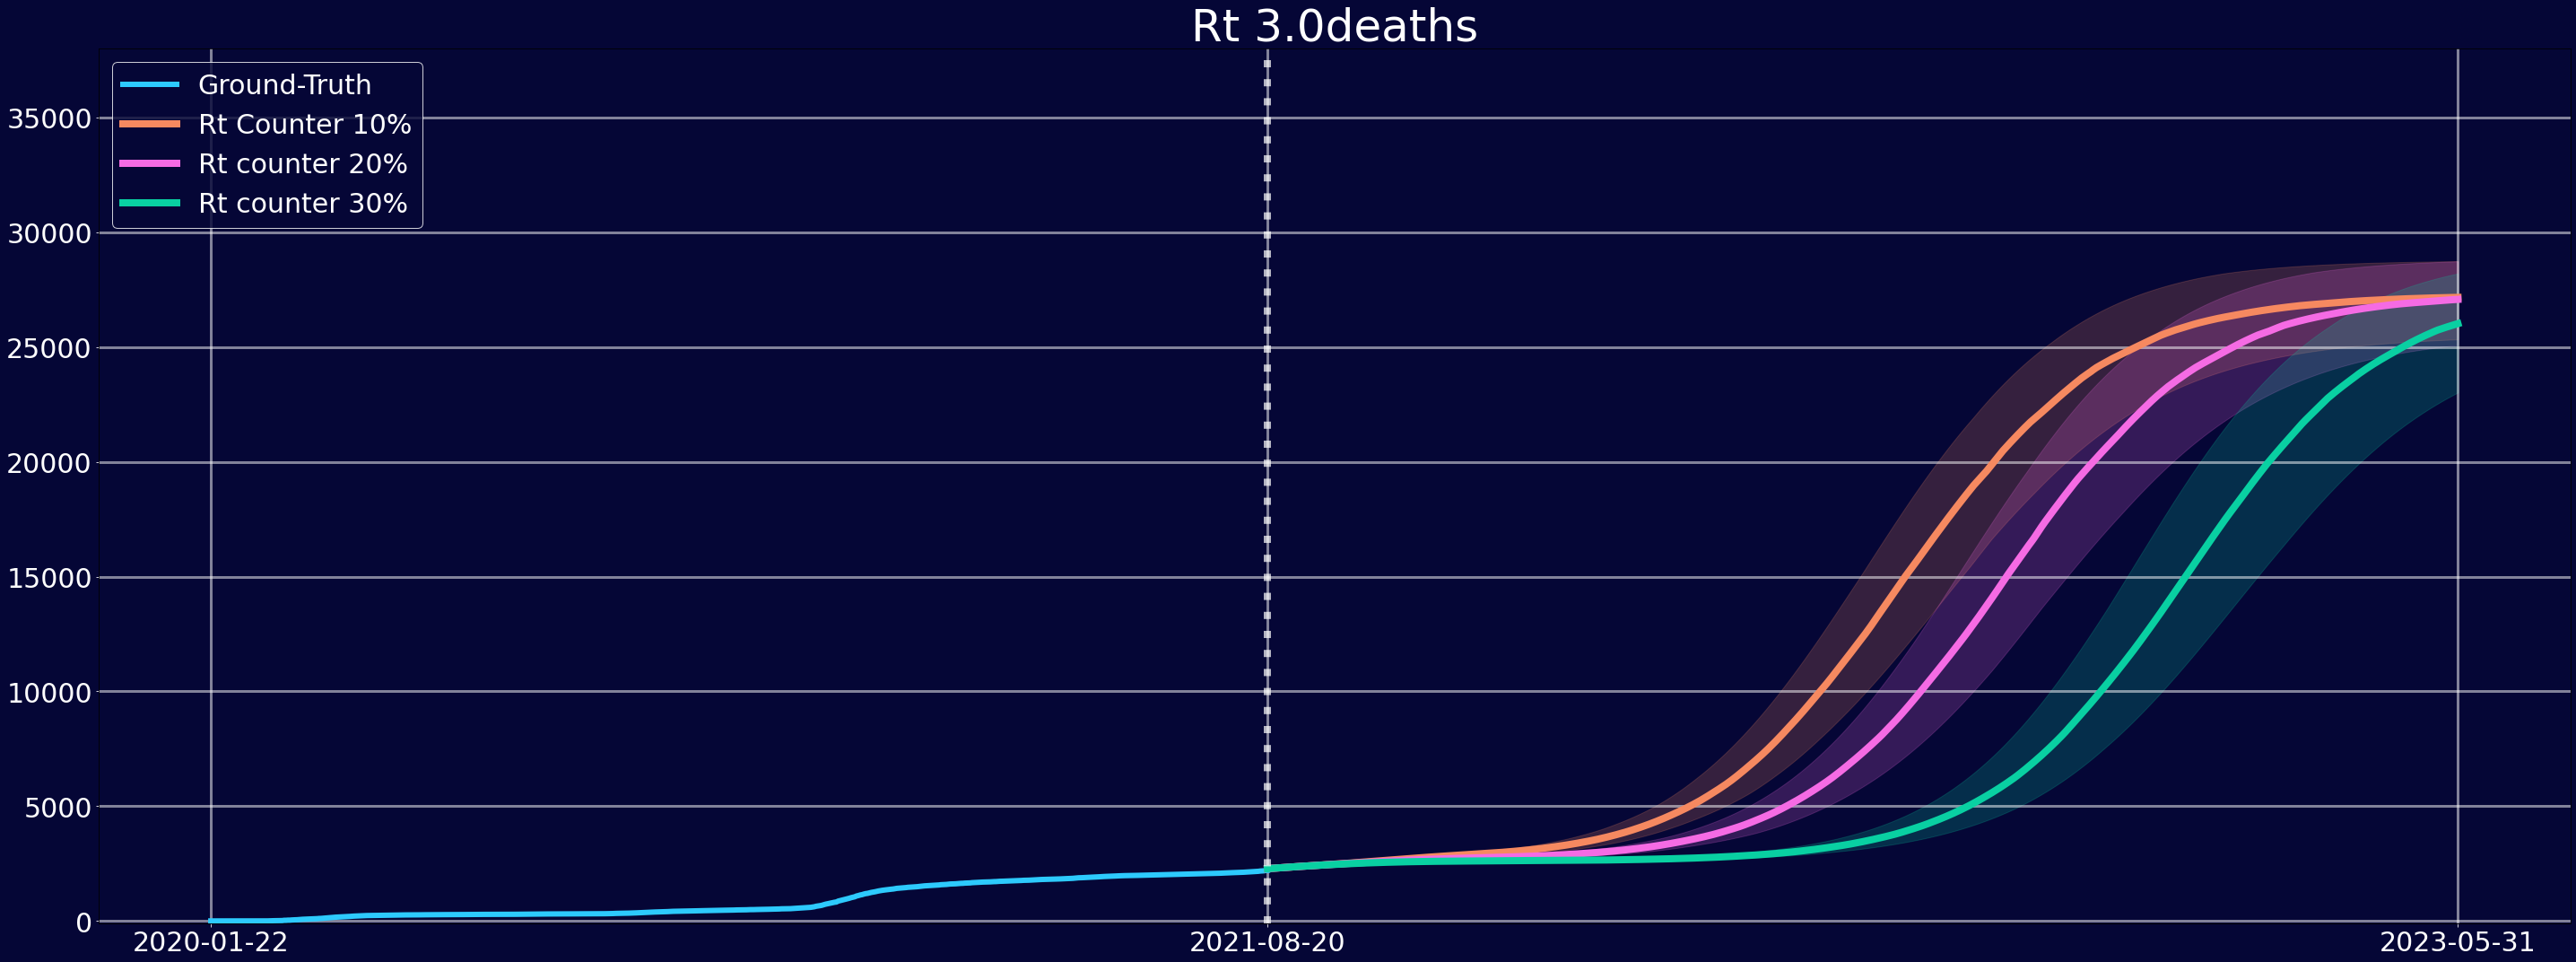

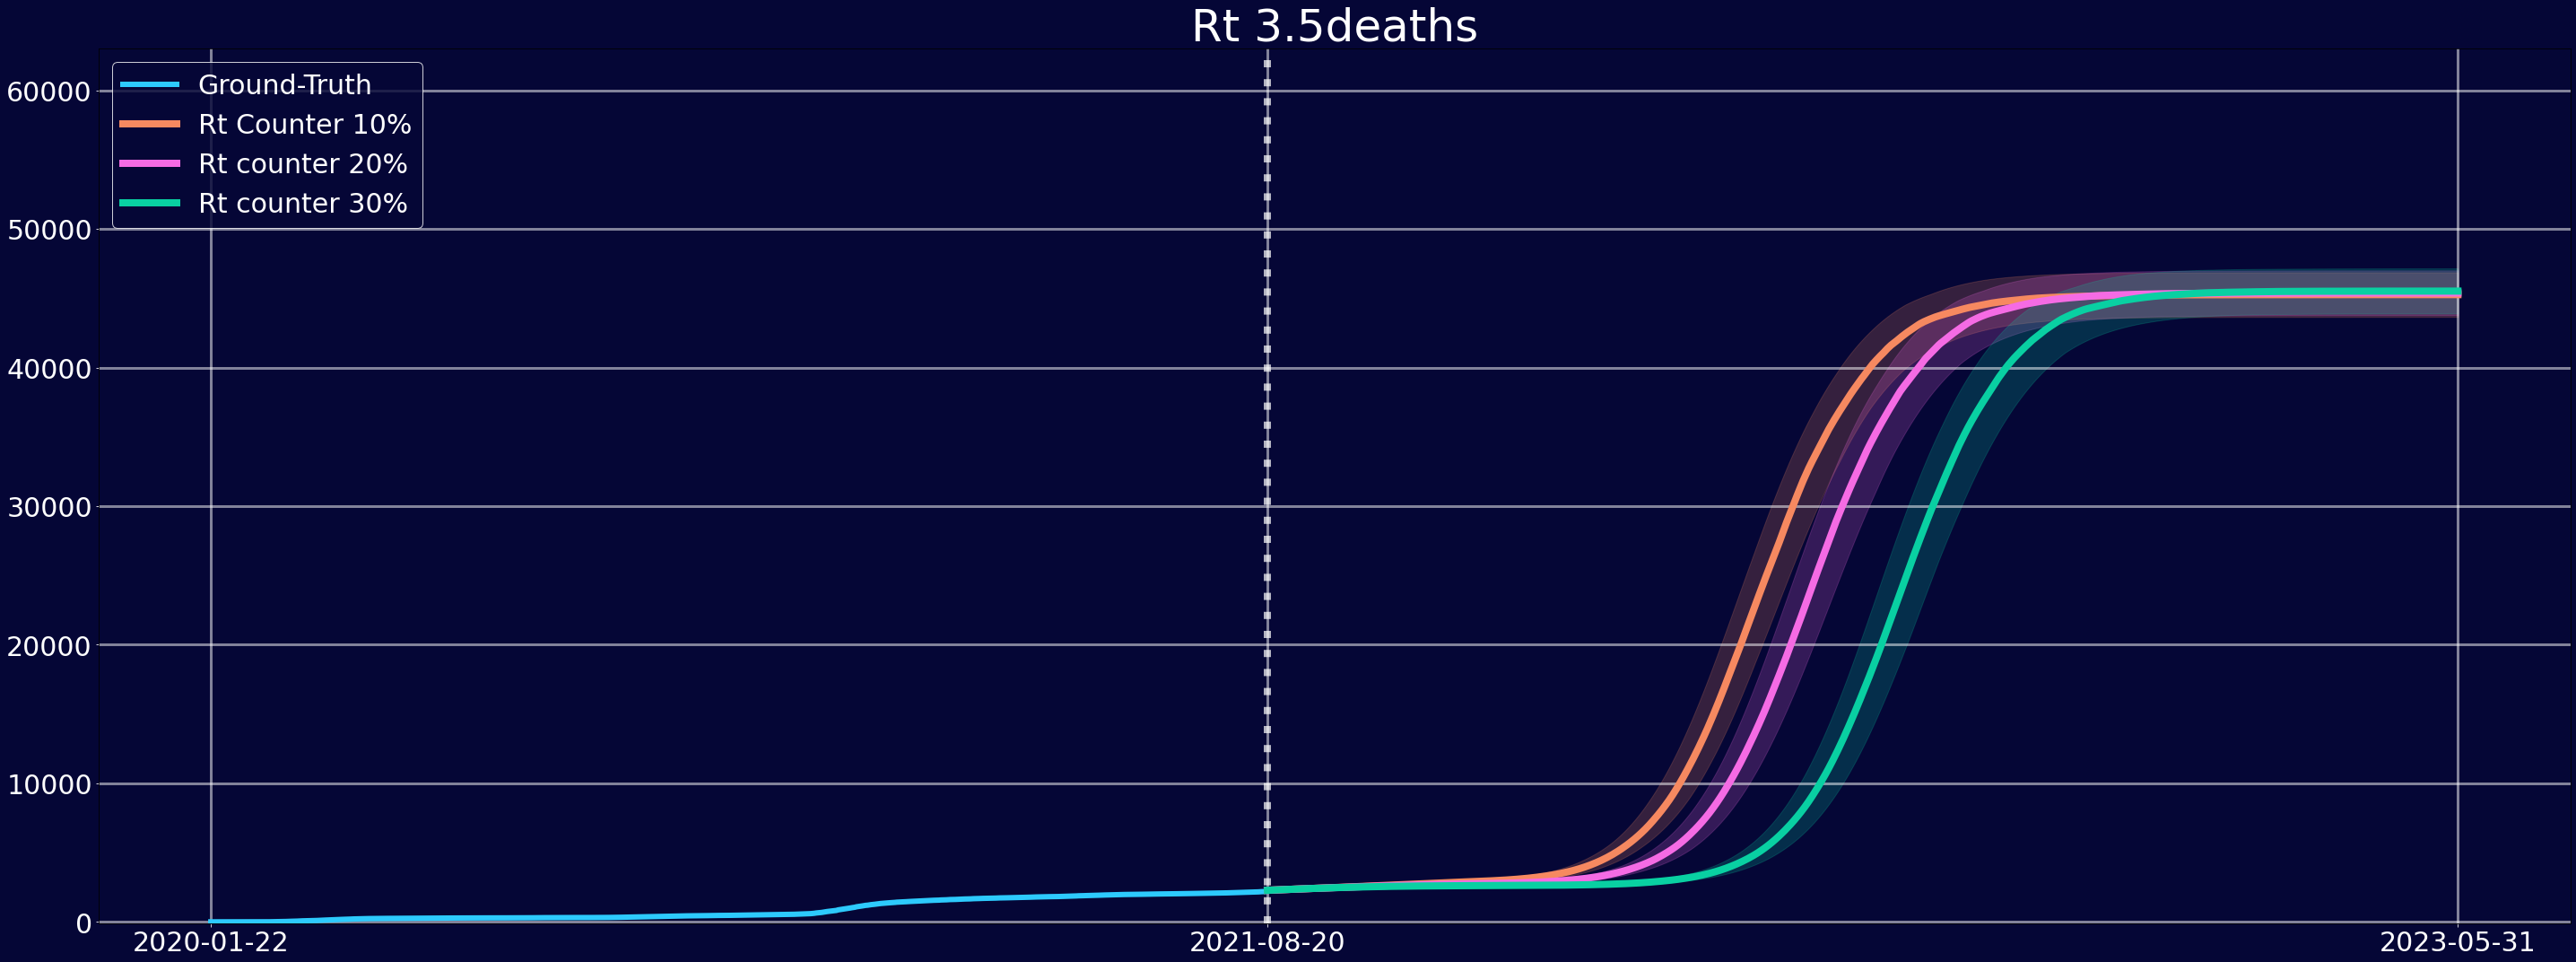

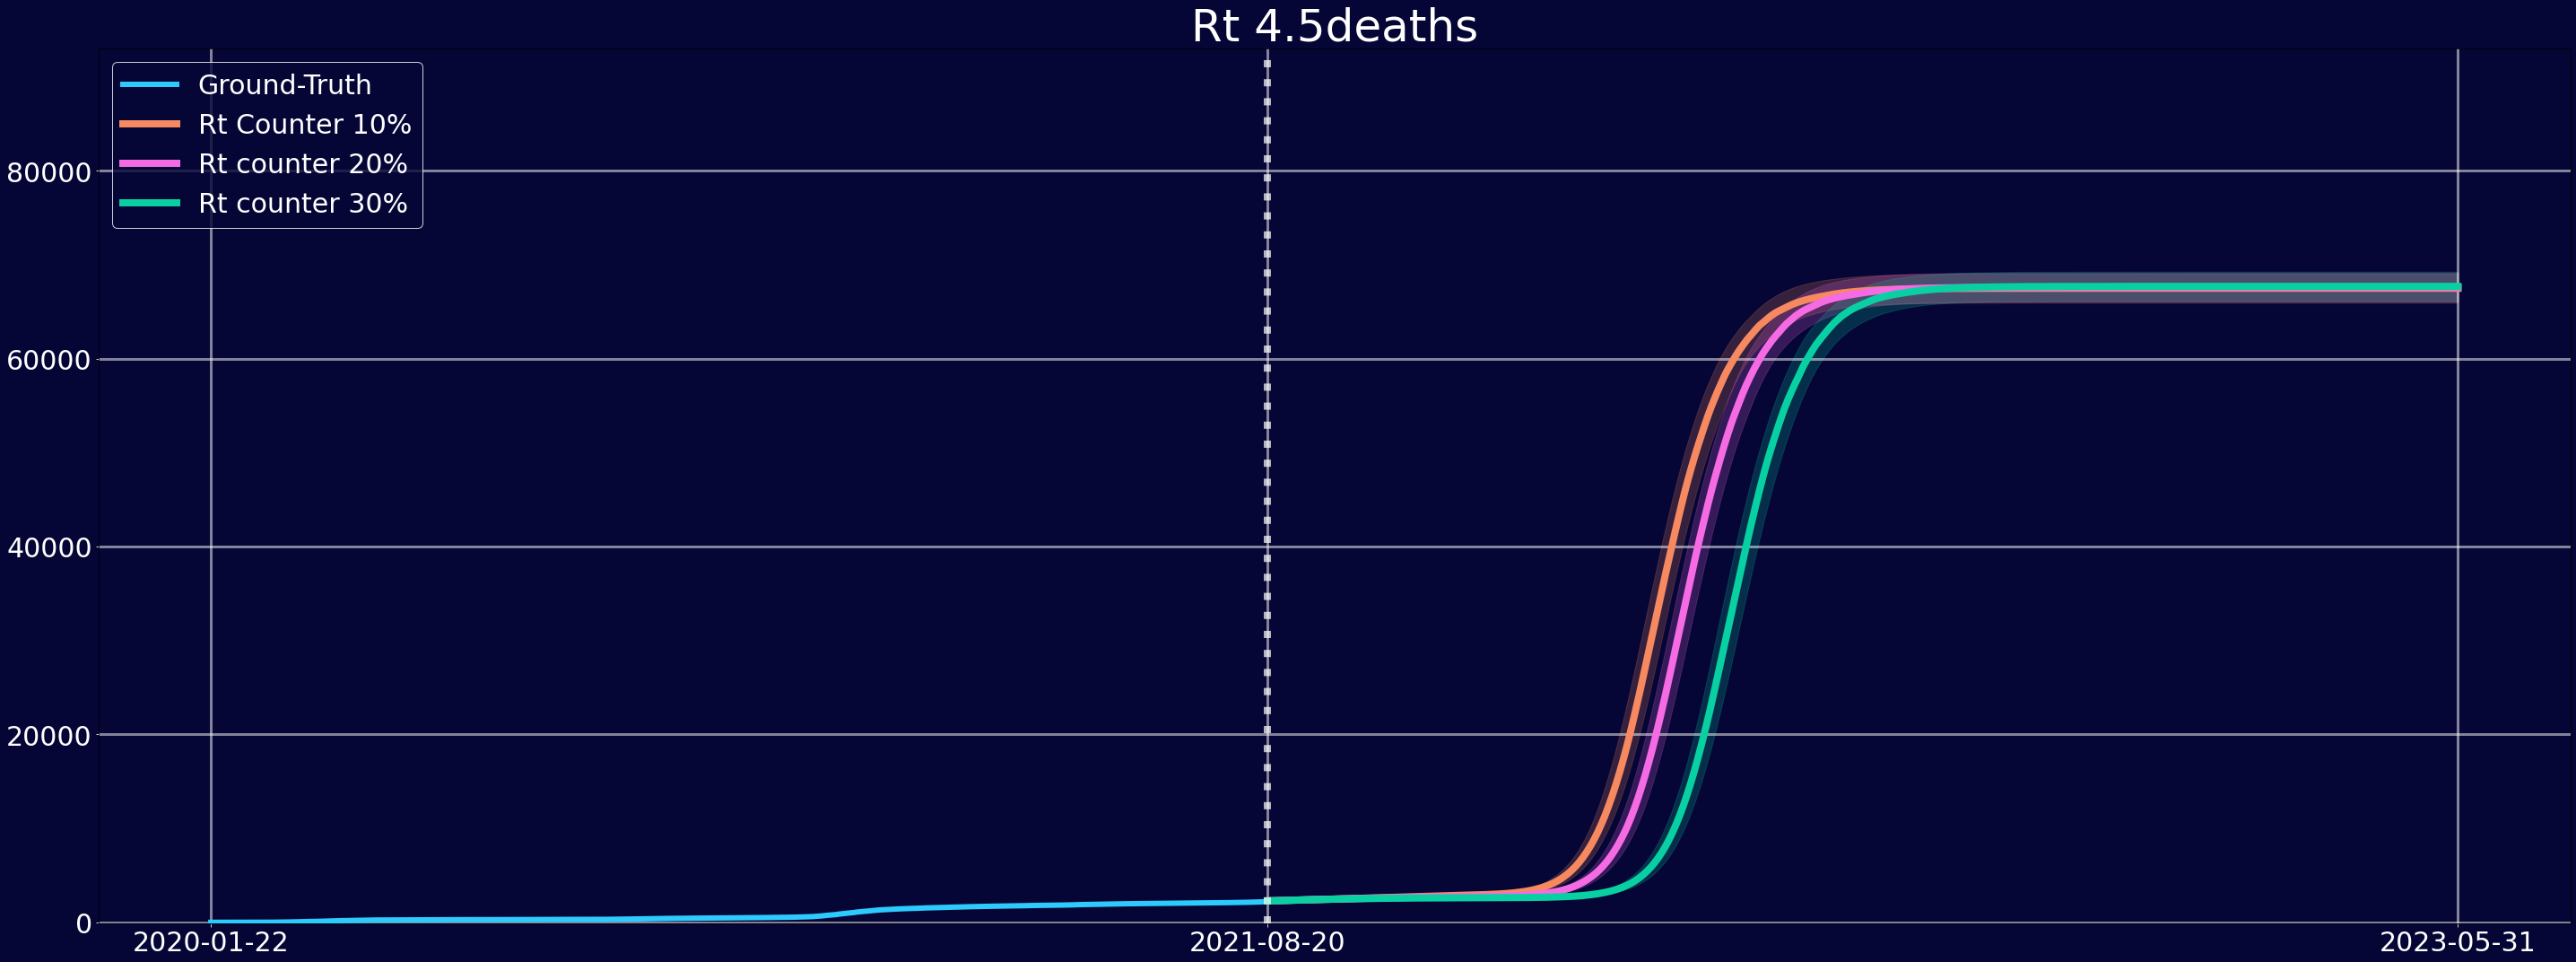

In [26]:
# rt_0_death = rt_0_death[rt_0_death['Date']>=pre_date]
# rt_1_death = rt_1_death[rt_1_death['Date']>=pre_date]
# rt_2_death = rt_2_death[rt_2_death['Date']>=pre_date]
# rt_3_death = rt_3_death[rt_3_death['Date']>=pre_date]
# rt_4_death = rt_4_death[rt_4_death['Date']>=pre_date]
Original_Plot('deaths',rt_0_death,Rt[0])
Original_Plot('deaths',rt_1_death,Rt[1])
Original_Plot('deaths',rt_2_death,Rt[2])
Original_Plot('deaths',rt_3_death,Rt[3])
Original_Plot('deaths',rt_4_death,Rt[4])

# 모든 Rt plot (new)

In [27]:
## Rt plot
def Rt_Plot(x,y,value):
    ################스타일#######################################
    fig = plt.figure(figsize=(40,15)) ## 캔버스 생성
    fig.patch.set_facecolor('#050636') 
    plt.rcParams['text.color'] = 'w'
    plt.rcParams['xtick.color'] = 'w'
    plt.rcParams['ytick.color'] = 'w'
    plt.rcParams['axes.spines.left'] = True
    plt.rcParams['axes.facecolor']='#050636'
    plt.grid(color='w', linestyle='-', linewidth=3,alpha = 0.5)
    plt.gca().spines['bottom'].set_visible(True) #위 테두리
    plt.gca().spines['left'].set_visible(True) #왼쪽 테두리
#     plt.ylim(y_lim)
    #############################################################
    
    
    
    v = ''
    if value =='Low':
        v = 'l'
    elif value == 'Base':
        v = 'b'
    else:
        v = 'h'
    
    if x == 'incidence':
        ground_truth = data_case
        column = 'Confirmed'
        plt_start_date = start_date
        offset = 0
        folder = 'I'
        plt.xticks([plt_start_date,'2020-05-01','2020-08-01','2020-11-01','2021-02-01','2021-05-01',pre_date,'2021-12-01','2022-03-01','2022-06-01','2022-09-01','2022-12-01','2023-03-01',end_date],[str(plt_start_date)[:10],'2020-05','2020-08','2020-11','2021-02','2021-05',str(pre_date)[:10],'2021-12','2022-03','2022-06','2022-09','2022-12','2023-03',str(end_date)[:10]],fontsize=30)

        
    elif x == 'deaths':
        ground_truth = data_case
        column = 'Cum_Deaths'
        plt_start_date = start_date
        offset = aug20_cum_deaths
        folder = 'D'
        plt.xticks([plt_start_date,'2020-05-01','2020-08-01','2020-11-01','2021-02-01','2021-05-01',pre_date,'2021-12-01','2022-03-01','2022-06-01','2022-09-01','2022-12-01','2023-03-01',end_date],[str(plt_start_date)[:10],'2020-05','2020-08','2020-11','2021-02','2021-05',str(pre_date)[:10],'2021-12','2022-03','2022-06','2022-09','2022-12','2023-03',str(end_date)[:10]],fontsize=30)

    else:
        ground_truth = old_severity
        column = 'Severity'
        plt_start_date = sev_start_date
        offset = 0
        folder = 'S'
        plt.xticks([plt_start_date,'2021-02-01','2021-05-01',pre_date,'2021-12-01','2022-03-01','2022-06-01','2022-09-01','2022-12-01','2023-03-01',end_date],[str(plt_start_date)[:10],'2021-02-01','2021-05-01',str(pre_date)[:10],'2021-12','2022-03','2022-06','2022-09','2022-12','2023-03',str(end_date)[:10]],fontsize=30)


   
    
    ################ Ground Truth #######################################
    plt.plot(ground_truth['tDate'], ground_truth[column],color = '#2dcafd',  linewidth = 6)
   
    
    ################ Rt[4] Data #######################################
    plt.plot(y['Date'], y[str(Rt[4])+'_'+v]+offset, color ='#7d72cf', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[4])+'_'+v+'_min']+offset,y[str(Rt[4])+'_'+v+'_max']+offset, color = '#7d72cf',alpha=0.3)

    
    ################ Rt[3] Data #######################################
    plt.plot(y['Date'], y[str(Rt[3])+'_'+v]+offset, color ='#3d77b6', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[3])+'_'+v+'_min']+offset,y[str(Rt[3])+'_'+v+'_max']+offset, color = '#3d77b6',alpha=0.3)
    
    
    ################ Rt[2] Data #######################################
    plt.plot(y['Date'], y[str(Rt[2])+'_'+v]+offset, color ='#09d0a2', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[2])+'_'+v+'_min']+offset,y[str(Rt[2])+'_'+v+'_max']+offset, color = '#09d0a2',alpha=0.3)
    
    
    ################ Rt[1] Data #######################################
    plt.plot(y['Date'], y[str(Rt[1])+'_'+v]+offset, color ='#f68960', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[1])+'_'+v+'_min']+offset,y[str(Rt[1])+'_'+v+'_max']+offset, color = '#f68960',alpha=0.3)
    
    
    ################ Rt[0] Data #######################################
    plt.plot(y['Date'], y[str(Rt[0])+'_'+v]+offset, color ='#f56be4', linewidth = 8)
    plt.fill_between(y['Date'], y[str(Rt[0])+'_'+v+'_min']+offset,y[str(Rt[0])+'_'+v+'_max']+offset, color = '#f56be4',alpha=0.3)
    
    
    ################ Legend #######################################
    plt.legend(['Ground-Truth','Rt '+str(Rt[4]),'Rt '+str(Rt[3]),'Rt '+str(Rt[2]),'Rt '+str(Rt[1]),'Rt '+str(Rt[0])],fontsize = 30,loc = 'upper left', edgecolor = 'w')


    plt.axvline(x = pre_date,linestyle = ':',color='w',linewidth=8, alpha = 0.7)
    file_name = file_name_date+"_None_None_"+value
#     plt.title(file_name,fontsize=50)
#     plt.suptitle(file_name, y=1, fontsize=30)
#     plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.tight_layout()
    plt.savefig(save_path+folder+"/"+file_name+".png",dpi=300)
    plt.show()

### 확진자

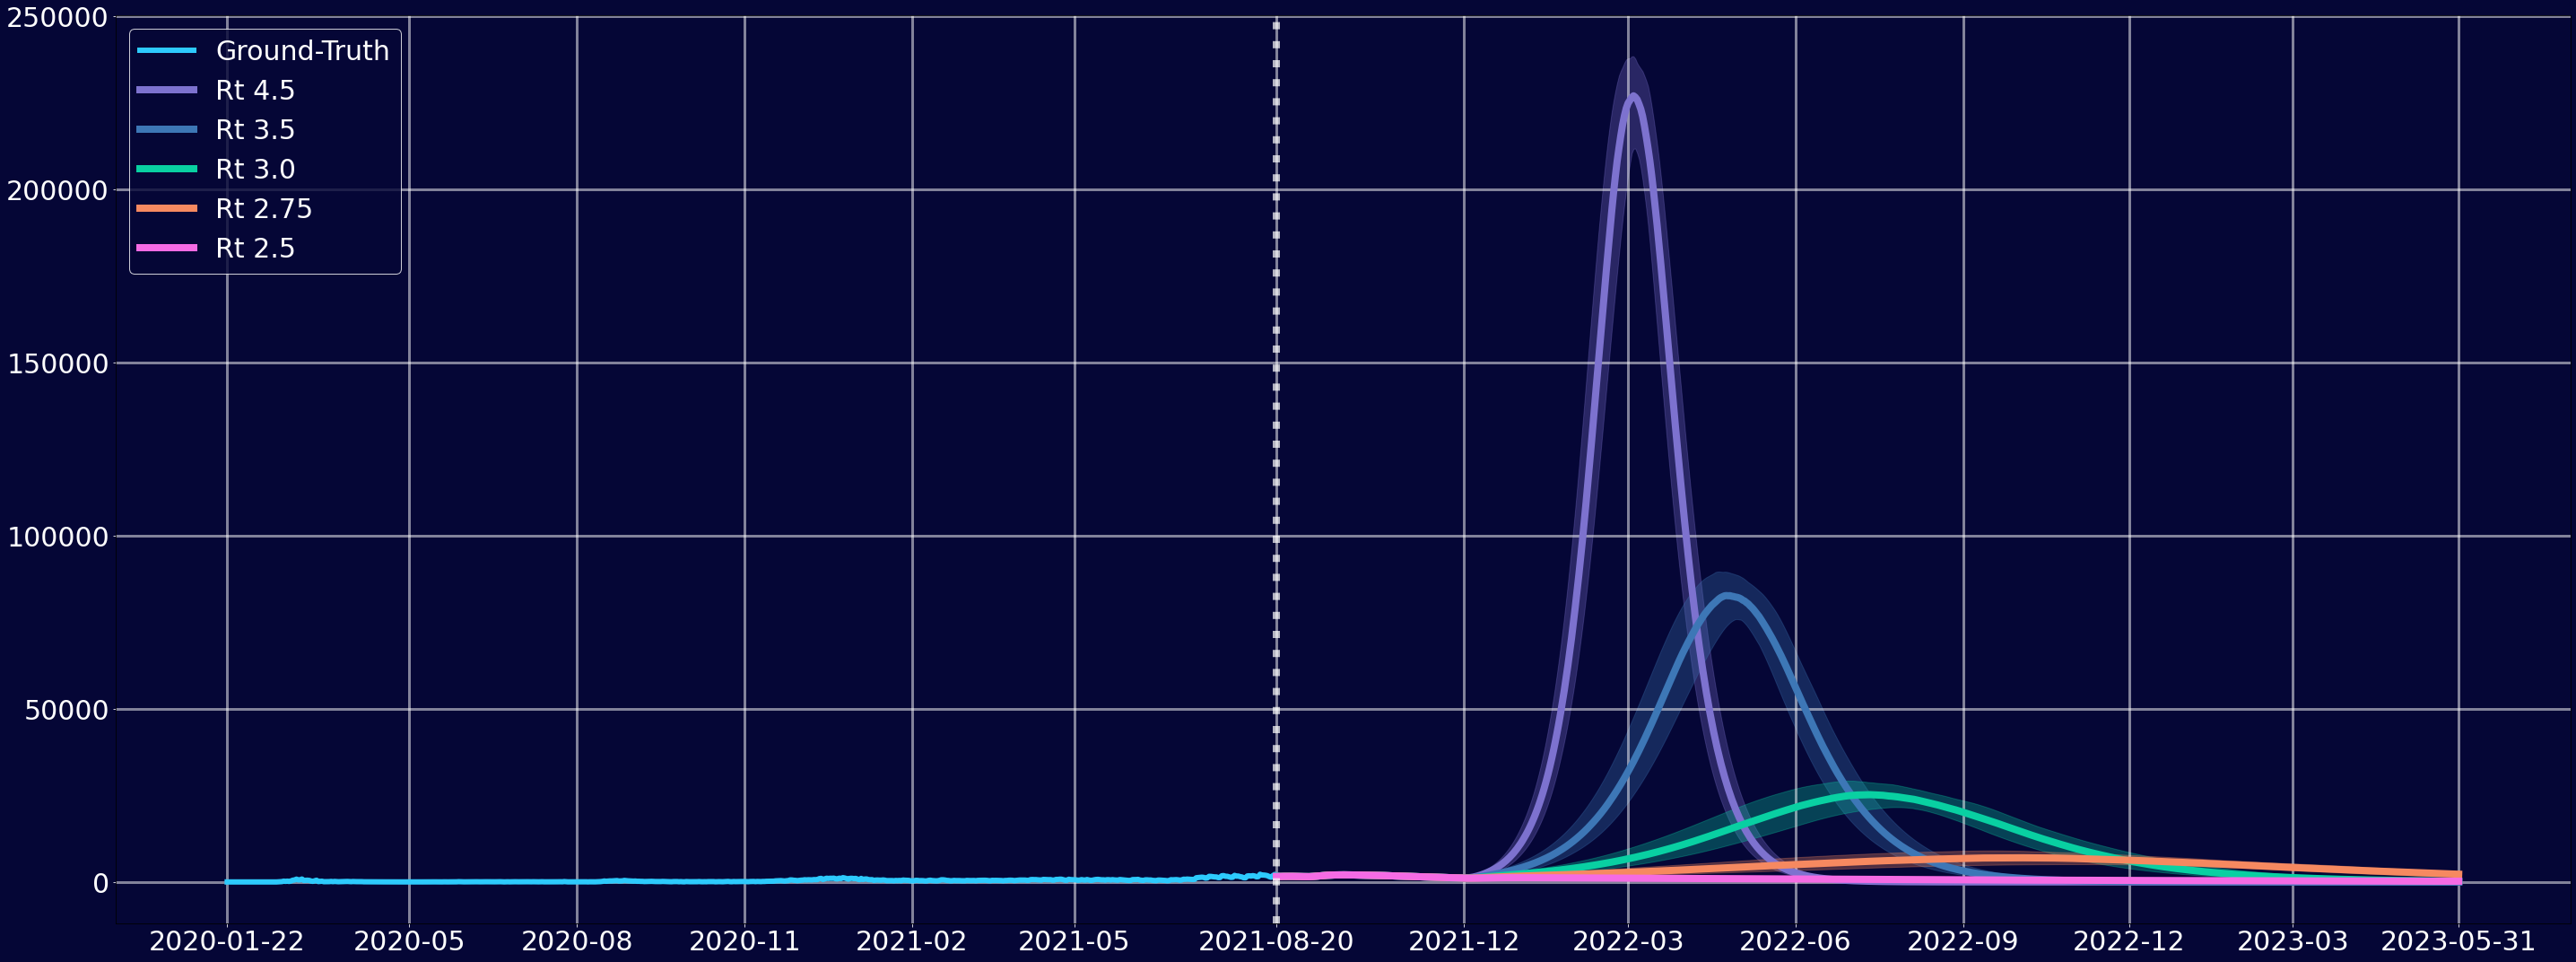

In [ ]:
Rt_Plot('incidence',incidence,'Low')
Rt_Plot('incidence',incidence,'Base')
Rt_Plot('incidence',incidence,'High')

### 중증자

In [ ]:
Rt_Plot('severity',severity,'Low')
Rt_Plot('severity',severity,'Base')
Rt_Plot('severity',severity,'High')

### 사망자

In [ ]:
Rt_Plot('deaths',deaths,'Low')
Rt_Plot('deaths',deaths,'Base')
Rt_Plot('deaths',deaths,'High')